<a href="https://colab.research.google.com/github/ArifAygun/Iron-Ore-Froth-Flotation-Quality-Prediction/blob/main/AA_Iron_Ore_Froth_Flotation_Quality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Quality Prediction of Iron Ore Mining Flotation Process**

##**1. Problem Definition**

**Gangue concentrate predict in the reverse cationic flotation:**


Mined ores are mostly mixtures of extractable minerals and nonvaluable material (gangue). Mineral processing (e.g. ore dressing, ore beneficiation) follows mining and prepares the ore for extraction of the valuable metal. A principal step in mineral processing is physical separation of the particles of valuable minerals from the gangue, to produce an enriched portion (concentrate) containing most of the valuable minerals, and a discard (tailing) containing predominantly the gangue.

A separation of minerals by exploiting difference of surface properties (hydrophobicity) is called flotation. **The reverse cationic flotation** is commonly used to separate iron from silica. By adjusting the 'chemistry' of the pulp by adding various chemical reagents, iron minerals remain in the water and create sediment with a high concentration of iron (valuable minerals). At the same time, silica particles (gangue) attach to air bubbles and float to the surface.

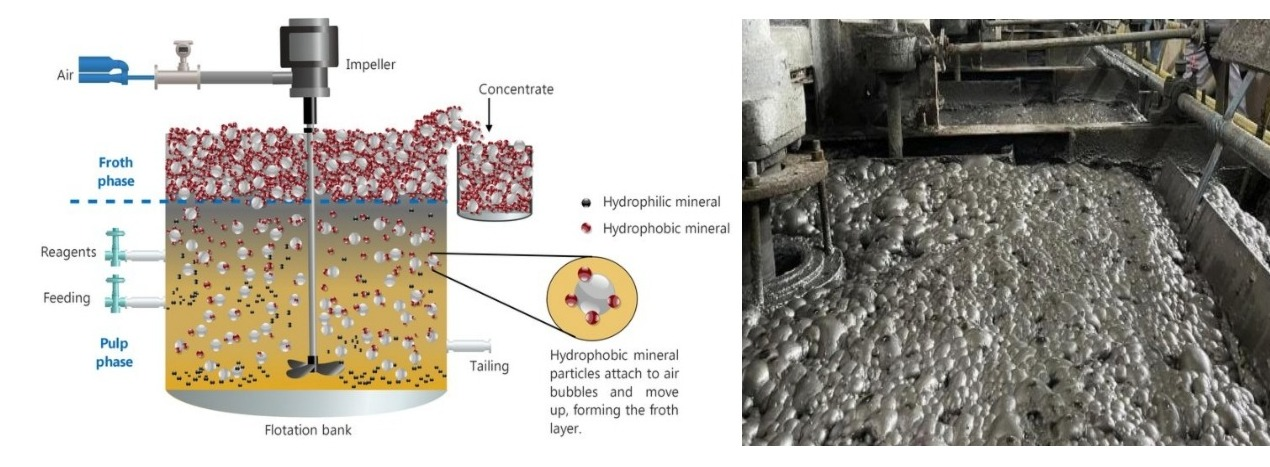

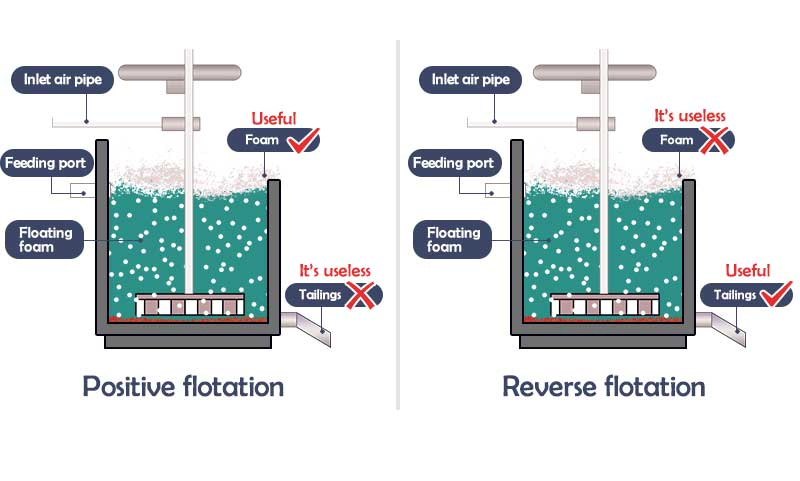

Flotation concentrate is periodically sampled to determine its purity (i.e., *%valuable*, *%gangue*). Higher *%gangue* in the concentrate is undesirable as it indicates that most valuable minerals had gone into the tailing. Purity measurement is usually done in a lab and can take some time before process engineers can make any adjustments based on the results. A timely investigation of concentrate purity is, therefore, a fundamental aspect for the control and optimization of the flotation process.

This project explores the application of machine learning to predict gangue (*%silica*) in the flotation concentrate. The prediction will help process engineers assess purity of flotation concentrate and take corrective actions in advance. More specifically, the goal is to tackle the following task:
- **To predict the last column (dependent variable), which is the % of silica in the iron ore concentrate.**

##**2. Data Understanding**

###**2.1. Data Definitions**

- **Date**: Data collection time.
- **% Iron Feed**: Feed grade of iron-containing ore.
- **% Silica Feed**: Feed grade of silica-containing ore.
- **Starch Flow**: Depressant chemical for Iron(Fe) containing ore measured in m³/h.
- **Amina Flow**: Collector chemical for Silica containing ore measured in m³/h.
- **Ore Pulp Flow**: The amount of pulp flow fed to the flotation columns as the product of the previous process step measured in t/h.
- **Ore Pulp pH**: pH is measured in pH scale.
- **Ore Pulp Density**: The solid percent of ore fed density ranges in kg/cm³
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Air Flow**: Air Flows that goes into the flotation cell measured in Nm³/h.
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Level**: Froth level in the flotation cell measured in mm.
- **% Iron Concentrate**: Concentrate grade of iron-containing ore in percentage.
- **% Silica Concentrate**: Concentrate grade of silica-containing ore in percentage

###**2.2. Inspection of the data**

- The first column shows time and date range (march 2017 -  september 2017). 
- Some columns were sampled every 20 second. Others were sampled on a hourly base.
- The second and third columns are quality measures of the iron ore pulp right before it is fed into the flotation plant. 
- From Column 4 until column 8 are the most important variables that impact in the ore quality in the end of the process. 
- From column 9 until column 22, we can see process data (froth level and air flow inside the flotation columns, which also impact in ore quality). 
- The last two columns are the final iron ore pulp quality measurement from the lab. 

##**3. Data Collection**

###**3.1. Import Libraries and Modules**

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
import os
import joblib
import warnings
warnings.filterwarnings("ignore")

###**3.2. Import Dataset**

In [32]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('Flotation_Plant.csv', decimal = ",")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


In [33]:
# Use a function to reduce memory usage of the dataframe by modifying the datatypes
def reduce_mem_usage(flotation, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = flotation.memory_usage().sum() / 1024**2    
    for col in flotation.columns:
        col_type = flotation[col].dtypes
        if col_type in numerics:
            c_min = flotation[col].min()
            c_max = flotation[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    flotation[col] = flotation[col].astype(np.int8)
                elif c_min > flotation.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       flotation[col] = flotation[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    flotation[col] = flotation[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    flotation[col] = flotation[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    flotation[col] = flotation[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    flotation[col] = flotation[col].astype(np.float32)
                else:
                    flotation[col] = flotation[col].astype(np.float64)    
    end_mem = flotation.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return flotation

In [34]:
flotation = reduce_mem_usage(flotation)

Mem. usage decreased to 70.33 Mb (47.9% reduction)


- Memory usage decrased from 135.0+ MB to 70.33 MB

##**4. Data Preprocessing**

###**4.1. Dataset information**

In [32]:
flotation.head()

date  % Iron Feed  % Silica Feed  Starch Flow  Amina Flow  \
0  2017-03-10 01:00:00    55.200001          16.98  3019.530029  557.434021   
1  2017-03-10 01:00:00    55.200001          16.98  3024.409912  563.965027   
2  2017-03-10 01:00:00    55.200001          16.98  3043.459961  568.054016   
3  2017-03-10 01:00:00    55.200001          16.98  3047.360107  568.664978   
4  2017-03-10 01:00:00    55.200001          16.98  3033.689941  558.166992   

   Ore Pulp Flow  Ore Pulp pH  Ore Pulp Density  Flotation Column 01 Air Flow  \
0     395.713013      10.0664              1.74                    249.214005   
1     397.382996      10.0672              1.74                    249.718994   
2     399.667999      10.0680              1.74                    249.740997   
3     397.938995      10.0689              1.74                    249.917007   
4     400.253998      10.0697              1.74                    250.203003   

   Flotation Column 02 Air Flow  ...  Flotation Column 07 Air Flow  \
0                    253.235001  ...                    250.884003   
1                    250.531998  ...                    248.994003   
2                    247.873993  ...                    248.070999   
3                    254.487000  ...                    251.147003   
4                    252.136002  ...                    248.927994   

   Flotation Column 01 Level  Flotation Column 02 Level  \
0                 457.395996                 432.962006   
1                 451.890991                 429.559998   
2                 451.239990                 468.927002   
3                 452.441010                 458.165009   
4                 452.441010                 452.899994   

   Flotation Column 03 Level  Flotation Column 04 Level  \
0                 424.954010                 443.558014   
1                 432.938995                 448.085999   
2                 434.609985                 449.687988   
3                 442.864990                 446.209991   
4                 450.523010                 453.670013   

   Flotation Column 05 Level  Flotation Column 06 Level  \
0                 502.255005                 446.369995   
1                 496.363007                 445.921997   
2                 484.411011                 447.825989   
3                 471.411011                 437.690002   
4                 462.597992                 443.682007   

   Flotation Column 07 Level  % Iron Concentrate  % Silica Concentrate  
0                 523.343994           66.910004                  1.31  
1                 498.075012           66.910004                  1.31  
2                 458.566986           66.910004                  1.31  
3                 427.669006           66.910004                  1.31  
4                 425.678986           66.910004                  1.31  

[5 rows x 24 columns]

In [35]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   date                          737453 non-null  object 
 1   % Iron Feed                   737453 non-null  float32
 2   % Silica Feed                 737453 non-null  float32
 3   Starch Flow                   737453 non-null  float32
 4   Amina Flow                    737453 non-null  float32
 5   Ore Pulp Flow                 737453 non-null  float32
 6   Ore Pulp pH                   737453 non-null  float32
 7   Ore Pulp Density              737453 non-null  float32
 8   Flotation Column 01 Air Flow  737453 non-null  float32
 9   Flotation Column 02 Air Flow  737453 non-null  float32
 10  Flotation Column 03 Air Flow  737453 non-null  float32
 11  Flotation Column 04 Air Flow  737453 non-null  float32
 12  Flotation Column 05 Air Flow  737453 non-nul

In [36]:
# Rename column names
old_columns = ['date', '% Iron Feed', '% Silica Feed', 'Starch Flow',
               'Amina Flow', 'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density', 
               'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow', 
               'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow', 
               'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow', 
               'Flotation Column 07 Air Flow', 
               'Flotation Column 01 Level', 'Flotation Column 02 Level', 
               'Flotation Column 03 Level', 'Flotation Column 04 Level', 
               'Flotation Column 05 Level', 'Flotation Column 06 Level', 
               'Flotation Column 07 Level',
               '% Iron Concentrate', '% Silica Concentrate']
new_columns = ["date", "iron_feed", "silica_feed", "starch_flow",
               "amina_flow", "pulp_flow", "pulp_pH", "pulp_density",
               "airflow_col1", "airflow_col2", "airflow_col3", "airflow_col4", 
               "airflow_col5", "airflow_col6", "airflow_col7", 
               "level_col1", "level_col2", "level_col3", "level_col4", "level_col5", 
               "level_col6", "level_col7", "iron_conc", "silica_conc"]

flotation = flotation.rename(columns=dict(zip(old_columns, new_columns)))
flotation.columns

Index(['date', 'iron_feed', 'silica_feed', 'starch_flow', 'amina_flow',
       'pulp_flow', 'pulp_pH', 'pulp_density', 'airflow_col1', 'airflow_col2',
       'airflow_col3', 'airflow_col4', 'airflow_col5', 'airflow_col6',
       'airflow_col7', 'level_col1', 'level_col2', 'level_col3', 'level_col4',
       'level_col5', 'level_col6', 'level_col7', 'iron_conc', 'silica_conc'],
      dtype='object')

###**4.2. Check Missing Values**

In [37]:
total = flotation.isnull().sum()
percent = (flotation.isnull().sum()/flotation.isnull().count())
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

Total  Percent
date              0      0.0
iron_feed         0      0.0
silica_feed       0      0.0
starch_flow       0      0.0
amina_flow        0      0.0
pulp_flow         0      0.0
pulp_pH           0      0.0
pulp_density      0      0.0
airflow_col1      0      0.0
airflow_col2      0      0.0
airflow_col3      0      0.0
airflow_col4      0      0.0
airflow_col5      0      0.0
airflow_col6      0      0.0
airflow_col7      0      0.0
level_col1        0      0.0
level_col2        0      0.0
level_col3        0      0.0
level_col4        0      0.0
level_col5        0      0.0
level_col6        0      0.0
level_col7        0      0.0
iron_conc         0      0.0
silica_conc       0      0.0

- No missing values across the dataframe

###**4.3. Check Duplicated Values**

In [38]:
#check duplicated rows
duplicate_rows = flotation[flotation.duplicated()]
duplicate_rows.shape

(1171, 24)

- There are 1171 duplicated values

In [39]:
#drop duplicated rows
flotation = flotation.drop_duplicates()

- Now dataset has 736282 data points.

- For further analysis "date" column will not be used, therefore we wil drop it. 

In [40]:
# Drop the 'date' column
flotation.drop('date', axis=1, inplace=True)

In [41]:
flotation.shape

(736282, 23)

###**4.4. Dataset summary statistics**

In [ ]:
# Plot corellation martix heatmap of variables
fig, ax = plt.subplots(figsize=(15, 15))
mask = np.triu(np.ones_like(flotation, dtype=bool))

sns.heatmap(flotation, mask=mask, 
            annot=True, fmt=".2f", cmap="YlGnBu")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.show()

In [42]:
# Calculate the correlation between 'silica_conc' and other variables
corr_with_target = flotation.corr()['silica_conc'].drop(
                   'silica_conc').sort_values(ascending=True)

print(corr_with_target)

iron_conc      -0.800598
airflow_col1   -0.219076
airflow_col3   -0.218834
level_col5     -0.168466
airflow_col2   -0.167259
level_col4     -0.148886
pulp_pH        -0.147211
level_col7     -0.140819
level_col6     -0.102115
iron_feed      -0.077179
airflow_col7   -0.071685
starch_flow    -0.066813
airflow_col6   -0.049692
airflow_col5   -0.008930
airflow_col4   -0.004770
pulp_flow       0.008497
level_col3      0.014843
level_col1      0.017859
level_col2      0.031790
pulp_density    0.047002
silica_feed     0.072676
amina_flow      0.156981
Name: silica_conc, dtype: float64


- "iron_conc" variable is highly correlated with target ("silica_conc") variable.
- We will drop the highly correlated feature.

In [43]:
# Drop the 'iron_conc' column
flotation.drop('iron_conc', axis=1, inplace=True)
flotation.head()

iron_feed  silica_feed  starch_flow  amina_flow   pulp_flow  pulp_pH  \
0  55.200001        16.98  3019.530029  557.434021  395.713013  10.0664   
1  55.200001        16.98  3024.409912  563.965027  397.382996  10.0672   
2  55.200001        16.98  3043.459961  568.054016  399.667999  10.0680   
3  55.200001        16.98  3047.360107  568.664978  397.938995  10.0689   
4  55.200001        16.98  3033.689941  558.166992  400.253998  10.0697   

   pulp_density  airflow_col1  airflow_col2  airflow_col3  ...  airflow_col6  \
0          1.74    249.214005    253.235001    250.576004  ...    250.225006   
1          1.74    249.718994    250.531998    250.862000  ...    250.136993   
2          1.74    249.740997    247.873993    250.313004  ...    251.345001   
3          1.74    249.917007    254.487000    250.048996  ...    250.421997   
4          1.74    250.203003    252.136002    249.895004  ...    249.983002   

   airflow_col7  level_col1  level_col2  level_col3  level_col4  level_col5  \
0    250.884003  457.395996  432.962006  424.954010  443.558014  502.255005   
1    248.994003  451.890991  429.559998  432.938995  448.085999  496.363007   
2    248.070999  451.239990  468.927002  434.609985  449.687988  484.411011   
3    251.147003  452.441010  458.165009  442.864990  446.209991  471.411011   
4    248.927994  452.441010  452.899994  450.523010  453.670013  462.597992   

   level_col6  level_col7  silica_conc  
0  446.369995  523.343994         1.31  
1  445.921997  498.075012         1.31  
2  447.825989  458.566986         1.31  
3  437.690002  427.669006         1.31  
4  443.682007  425.678986         1.31  

[5 rows x 22 columns]

In [45]:
flotation.shape

(736282, 22)

In [46]:
flotation.describe().T

count         mean          std         min          25%  \
iron_feed     736282.0    56.298321     5.160365   42.740002    52.669998   
silica_feed   736282.0    14.648984     6.810741    1.310000     8.940000   
starch_flow   736282.0  2869.636719  1216.017944    0.002026  2075.070068   
amina_flow    736282.0   488.165405    91.254433  241.669006   431.835838   
pulp_flow     736282.0   397.570587     9.705443  376.248993   394.247986   
pulp_pH       736282.0     9.767312     0.387176    8.753340     9.527050   
pulp_density  736282.0     1.680424     0.069206    1.519820     1.647390   
airflow_col1  736282.0   280.119843    29.633831  175.509995   250.278000   
airflow_col2  736282.0   277.121307    30.157125  175.156006   250.447998   
airflow_col3  736282.0   281.052551    28.571077  176.468994   250.847000   
airflow_col4  736282.0   299.446198     2.573804  292.195007   298.256989   
airflow_col5  736282.0   299.914856     3.637019  286.295013   298.069000   
airflow_col6  736282.0   292.065704    30.241329  189.927994   260.299759   
airflow_col7  736282.0   290.740570    28.690519  185.962006   256.047745   
level_col1    736282.0   520.168396   131.085815  149.218002   416.902008   
level_col2    736282.0   522.555298   128.216232  210.751999   441.835243   
level_col3    736282.0   531.283875   150.931870  126.254997   411.256012   
level_col4    736282.0   420.169678    91.755821  162.201004   356.627014   
level_col5    736282.0   425.094513    84.479172  166.990997   357.595253   
level_col6    736282.0   429.889557    89.919586  155.841003   358.437988   
level_col7    736282.0   420.910248    84.899170  175.348999   356.705238   
silica_conc   736282.0     2.327270     1.125616    0.600000     1.440000   

                      50%          75%          max  
iron_feed       56.080002    59.720001    65.779999  
silica_feed     13.850000    19.600000    33.400002  
starch_flow   3020.229980  3728.929932  6300.229980  
amina_flow     504.352493   553.335754   739.538025  
pulp_flow      399.238007   402.967010   418.640991  
pulp_pH          9.797460    10.037800    10.808100  
pulp_density     1.697580     1.728380     1.853250  
airflow_col1   299.341003   300.147003   373.871002  
airflow_col2   296.201996   300.686005   375.992004  
airflow_col3   298.690002   300.385010   364.346008  
airflow_col4   299.803986   300.635010   305.871002  
airflow_col5   299.885986   301.785004   310.269989  
airflow_col6   299.485992   303.076996   370.910004  
airflow_col7   299.002014   301.907013   371.592987  
level_col1     491.748993   594.097763   862.273987  
level_col2     495.853500   595.293030   828.919006  
level_col3     494.183990   601.299011   886.822021  
level_col4     411.770493   485.285004   680.359009  
level_col5     408.649994   484.007996   675.643982  
level_col6     424.427002   492.773010   698.861023  
level_col7     410.940002   476.144989   659.901978  
silica_conc      2.000000     3.010000     5.530000


- **iron_feed**: Percentage of iron in the slurry being fed to the flotation cells (0-100%). (Min 42.74%, max 65.78%)
- **silica_feed**: Percentage of silica in the slurry being fed to the flotation cells. (0-100%). (Min 1.31%, max 33.4%)
- **starch_flow**: Flow rate of starch (reactive) measured in m3/h. (min 0.002026 m3/h, max 6300.23 m3/h)
- **amina_flow**: Flow rate of amine (reactive) measured in m3/h. (min 241.669 m3/h, max 739.538 m3/h)
- **pulp_flow**: Feed flow rate of pulp measured in t/h. (min 376.249 t/h, max 418.641 m3/h)
- **pulp_pH**: pH of the pulp, scale from 0 to 14. (min 8.7533 ph, max 10.808ph)
- **pulp_density**: Density of the pulp measured in kg/cm³. (min 1.519 kg/cm3, max 1.853 kg/cm3)
- **airflow_col1**: Air flow rate entering flotation cell 1, measured in Nm³/h. (min 175.510 Nm3/h, max 373.871 Nm3/h)
- **airflow_col2**: Air flow rate entering flotation cell 2, measured in Nm³/h. (min 175.156 Nm3/h, max 375.992 Nm3/h)
- **airflow_col3**: Air flow rate entering flotation cell 3, measured in Nm³/h. (min 176.469 Nm3/h, max 364.346 Nm3/h)
- **airflow_col4**: Air flow rate entering flotation cell 4, measured in Nm³/h. (min 292.195 Nm3/h, max 305.871 Nm3/h)
- **airflow_col5**: Air flow rate entering flotation cell 5, measured in Nm³/h. (min 286.295 Nm3/h, max 310.27 Nm3/h)
- **airflow_col6**: Air flow rate entering flotation cell 6, measured in Nm³/h. (min 189.928 Nm3/h, max 370.91 Nm3/h)
- **airflow_col7**: Air flow rate entering flotation cell 7, measured in Nm³/h. (min 185.962 Nm3/h, max 371.593 Nm3/h)
- **level_col1**: Height of the bubble layer at the top of flotation cell 1, measured in mm. (min 149.2 mm, max 862.2 mm)
- **level_col2**: Height of the bubble layer at the top of flotation cell 2, measured in mm. (min 210.7 mm, max 828.9 mm)
- **level_col3**: Height of the bubble layer at the top of flotation cell 3, measured in mm. (min 126.2 mm, max 886.8 mm)
- **level_col4**: Height of the bubble layer at the top of flotation cell 4, measured in mm. (min 162.2 mm, max 680.3 mm)
- **level_col5**: Height of the bubble layer at the top of flotation cell 5, measured in mm. (min 166.9 mm, max 675.6 mm)
- **level_col6**: Height of the bubble layer at the top of flotation cell 6, measured in mm. (min 155.8 mm, max 698.8 mm)
- **level_col7**: Height of the bubble layer at the top of flotation cell 7, measured in mm. (min 175.3 mm, max 659.9 mm)


**```Target Variable```**
- **silica_conc**: Percentage of silica in the concentrate at the end of the flotation process, (min 0.6%, max 5.63%) 

- Dataset variables have very wide range data point values.


###**4.5. Dataset normalisation**

- Normalizing the dataset is necessary to bring the features or variables to a similar scale or range.

In [48]:
from sklearn.preprocessing import MinMaxScaler

# Select the columns to normalize
columns_to_normalize = ["iron_feed", "silica_feed", "starch_flow", "amina_flow", "pulp_flow",
                        "pulp_pH", "pulp_density", "airflow_col1", "airflow_col2", "airflow_col3",
                        "airflow_col4", "airflow_col5", "airflow_col6", "airflow_col7", "level_col1",
                        "level_col2", "level_col3", "level_col4", "level_col5", "level_col6",
                        "level_col7", "silica_conc"]

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Apply Min-Max scaling to the selected columns
flotation[columns_to_normalize] = scaler.fit_transform(flotation[columns_to_normalize])


In [49]:
flotation.head()

iron_feed  silica_feed  starch_flow  amina_flow  pulp_flow   pulp_pH  \
0   0.540799     0.488314     0.479273    0.634233   0.459144  0.639033   
1   0.540799     0.488314     0.480047    0.647351   0.498538  0.639422   
2   0.540799     0.488314     0.483071    0.655564   0.552440  0.639812   
3   0.540799     0.488314     0.483690    0.656791   0.511653  0.640250   
4   0.540799     0.488314     0.481520    0.635705   0.566262  0.640639   

   pulp_density  airflow_col1  airflow_col2  airflow_col3  ...  airflow_col6  \
0      0.660348      0.371565      0.388770      0.394444  ...      0.333166   
1      0.660348      0.374111      0.375311      0.395967  ...      0.332680   
2      0.660348      0.374222      0.362076      0.393044  ...      0.339354   
3      0.660348      0.375109      0.395004      0.391639  ...      0.334254   
4      0.660348      0.376551      0.383298      0.390820  ...      0.331829   

   airflow_col7  level_col1  level_col2  level_col3  level_col4  level_col5  \
0      0.349737    0.432193    0.359466    0.392732    0.542995    0.659121   
1      0.339555    0.424473    0.353963    0.403231    0.551733    0.647538   
2      0.334583    0.423560    0.417646    0.405428    0.554825    0.624040   
3      0.351154    0.425244    0.400237    0.416282    0.548113    0.598483   
4      0.339200    0.425244    0.391719    0.426350    0.562510    0.581156   

   level_col6  level_col7  silica_conc  
0    0.535025    0.718177     0.144016  
1    0.534199    0.666028     0.144016  
2    0.537706    0.584493     0.144016  
3    0.519040    0.520727     0.144016  
4    0.530074    0.516620     0.144016  

[5 rows x 22 columns]

In [50]:
# describe dataset after normalisation
flotation.describe().T

count      mean       std  min       25%       50%       75%  \
iron_feed     736282.0  0.588468  0.223974  0.0  0.430990  0.578993  0.736979   
silica_feed   736282.0  0.415674  0.212239  0.0  0.237769  0.390776  0.569959   
starch_flow   736282.0  0.455481  0.193012  0.0  0.329364  0.479384  0.591872   
amina_flow    736282.0  0.495103  0.183290  0.0  0.381962  0.527616  0.626001   
pulp_flow     736282.0  0.502966  0.228945  0.0  0.424584  0.542296  0.630260   
pulp_pH       736282.0  0.493476  0.188429  0.0  0.376545  0.508147  0.625114   
pulp_density  736282.0  0.481672  0.207557  0.0  0.382599  0.533125  0.625498   
airflow_col1  736282.0  0.527371  0.149393  0.0  0.376929  0.624271  0.628334   
airflow_col2  736282.0  0.507704  0.150158  0.0  0.374893  0.602711  0.625037   
airflow_col3  736282.0  0.556660  0.152073  0.0  0.395887  0.650537  0.659559   
airflow_col4  736282.0  0.530215  0.188199  0.0  0.443258  0.556376  0.617140   
airflow_col5  736282.0  0.568084  0.151701  0.0  0.491095  0.566881  0.646090   
airflow_col6  736282.0  0.564353  0.167096  0.0  0.388833  0.605353  0.625195   
airflow_col7  736282.0  0.564445  0.154557  0.0  0.377554  0.608950  0.624599   
level_col1    736282.0  0.520226  0.183837  0.0  0.375404  0.480370  0.623906   
level_col2    736282.0  0.504400  0.207414  0.0  0.373820  0.461205  0.622067   
level_col3    736282.0  0.532535  0.198446  0.0  0.374722  0.483756  0.624592   
level_col4    736282.0  0.497857  0.177081  0.0  0.375225  0.481647  0.623524   
level_col5    736282.0  0.507426  0.166084  0.0  0.374724  0.475096  0.623248   
level_col6    736282.0  0.504675  0.165592  0.0  0.373093  0.494615  0.620478   
level_col7    736282.0  0.506779  0.175211  0.0  0.374275  0.486203  0.620770   
silica_conc   736282.0  0.350359  0.228320  0.0  0.170385  0.283976  0.488844   

              max  
iron_feed     1.0  
silica_feed   1.0  
starch_flow   1.0  
amina_flow    1.0  
pulp_flow     1.0  
pulp_pH       1.0  
pulp_density  1.0  
airflow_col1  1.0  
airflow_col2  1.0  
airflow_col3  1.0  
airflow_col4  1.0  
airflow_col5  1.0  
airflow_col6  1.0  
airflow_col7  1.0  
level_col1    1.0  
level_col2    1.0  
level_col3    1.0  
level_col4    1.0  
level_col5    1.0  
level_col6    1.0  
level_col7    1.0  
silica_conc   1.0

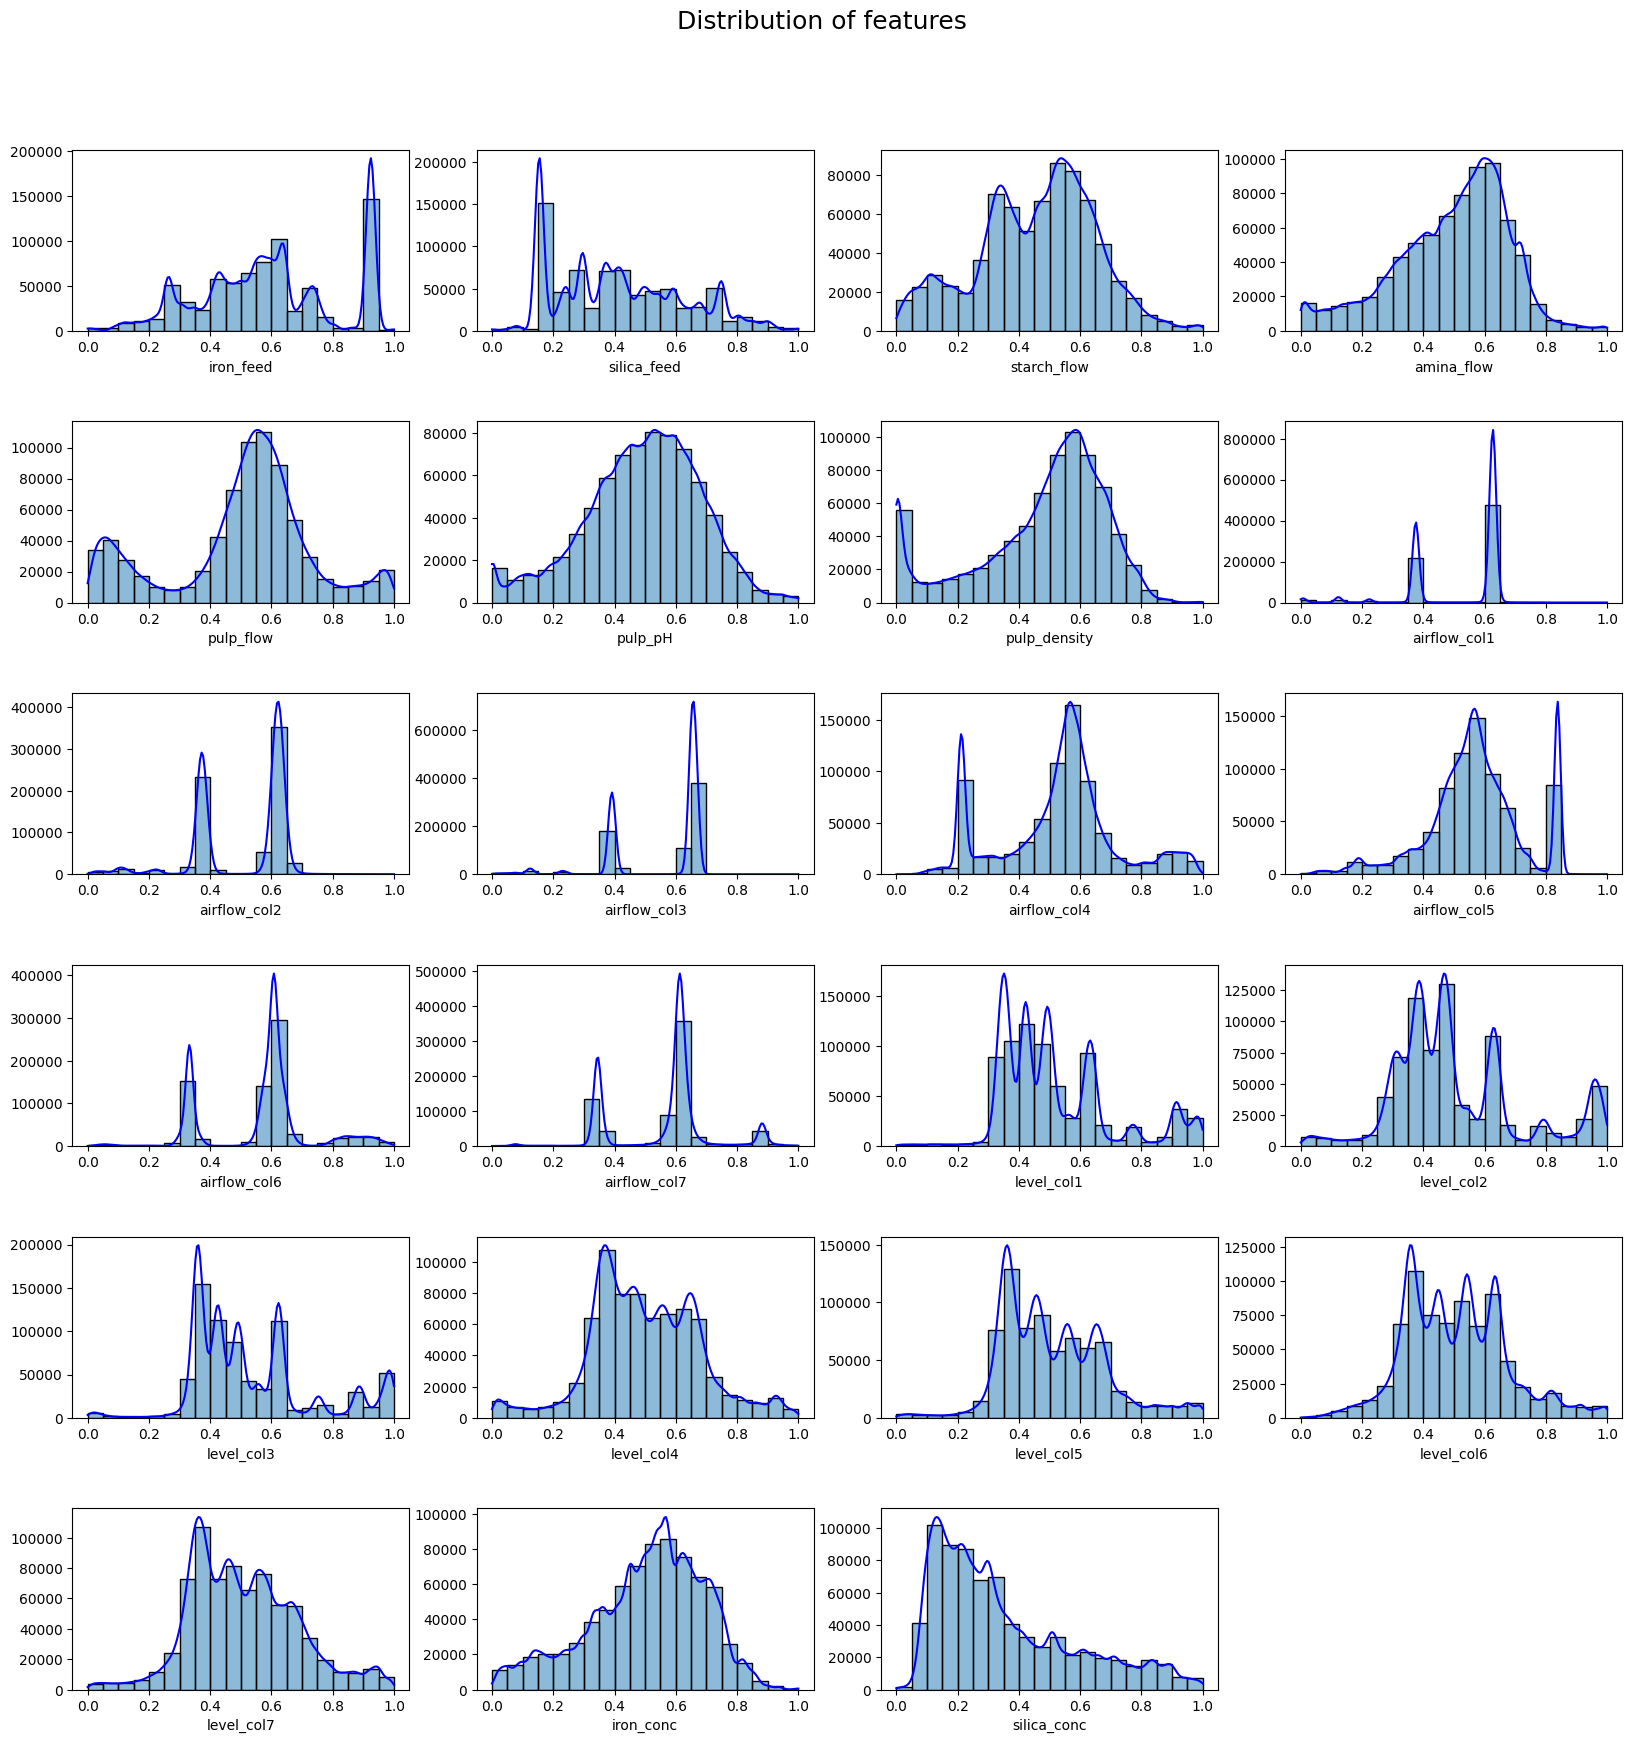

In [ ]:
# histogram of the features
features = flotation.columns
plt.figure(figsize= (20,20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Distribution of features", fontsize=18, y=0.95)
for i, feature in enumerate(features):
 k = i + 1
 plt.subplot(6,4,int(k))
 sns.histplot(data=flotation, x=feature, kde=True, bins = 20).lines[0].set_color('blue')
 plt.xlabel(feature)
 plt.ylabel("")
plt.show()

###**4.6. Check skewness**

In [ ]:
import pandas as pd
import numpy as np

def calculate_skewness(data):
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    skewness = (1/n) * np.sum((data - mean)**3) / std**3
    return skewness


# Selecting the variables for skewness calculation
variables = ["iron_feed", "silica_feed", "starch_flow", "amina_flow", "pulp_flow",
             "pulp_pH", "pulp_density", "airflow_col1", "airflow_col2", "airflow_col3",
             "airflow_col4", "airflow_col5", "airflow_col6", "airflow_col7", "level_col1",
             "level_col2", "level_col3", "level_col4", "level_col5", "level_col6",
             "level_col7", "iron_conc", "silica_conc"]

# Calculate skewness for each variable
skewness_results = {}
for variable in variables:
    data = flotation[variable].values
    skewness = calculate_skewness(data)
    skewness_results[variable] = skewness

# Print the skewness results
for variable, skewness in skewness_results.items():
    print("Skewness for", variable, ":", skewness)


Skewness for iron_feed : 0.00041304696792240475
Skewness for silica_feed : 0.4397081119363925
Skewness for starch_flow : -0.24258915159667213
Skewness for amina_flow : -0.5684128405264899
Skewness for pulp_flow : -0.47096015246332906
Skewness for pulp_pH : -0.3510411467988553
Skewness for pulp_density : -0.8748216253387547
Skewness for airflow_col1 : -1.300097374185516
Skewness for airflow_col2 : -0.8827192374700609
Skewness for airflow_col3 : -1.2420812274930098
Skewness for airflow_col4 : -0.05012623656558369
Skewness for airflow_col5 : -0.297148925064671
Skewness for airflow_col6 : -0.11556223504540256
Skewness for airflow_col7 : -0.20868515032924473
Skewness for level_col1 : 0.9833420675464534
Skewness for level_col2 : 0.7452427784032196
Skewness for level_col3 : 0.8206747348393151
Skewness for level_col4 : 0.09900997598685346
Skewness for level_col5 : 0.5745912467853092
Skewness for level_col6 : 0.40214860590216706
Skewness for level_col7 : 0.34745316491060985
Skewness for iron_co

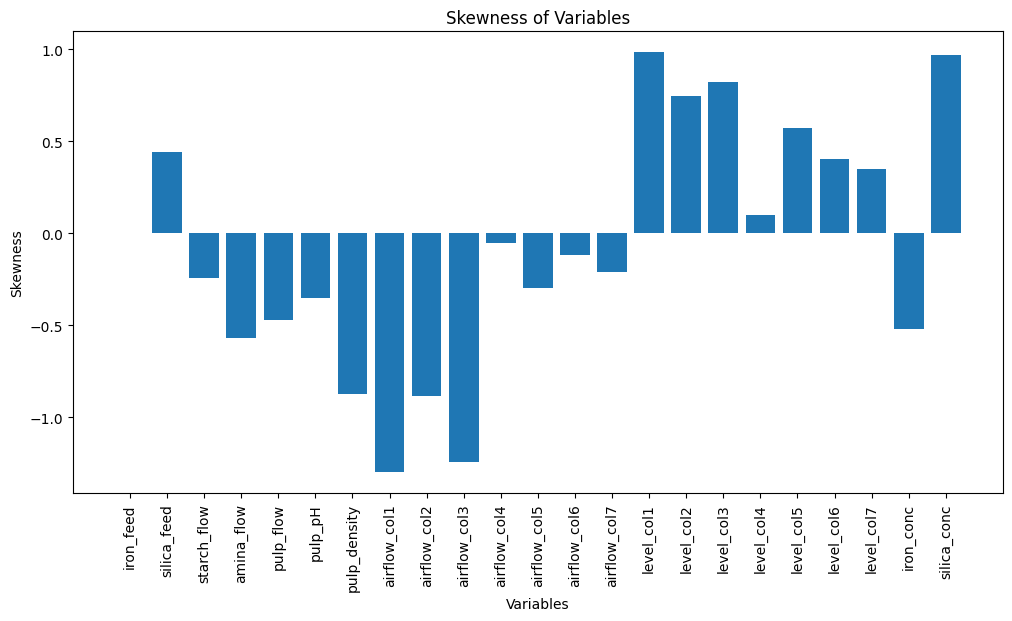

In [ ]:
import matplotlib.pyplot as plt

# Extract variable names and skewness values
variable_names = list(skewness_results.keys())
skewness_values = list(skewness_results.values())

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(variable_names, skewness_values)
plt.xlabel("Variables")
plt.ylabel("Skewness")
plt.title("Skewness of Variables")
plt.xticks(rotation=90)
plt.show()


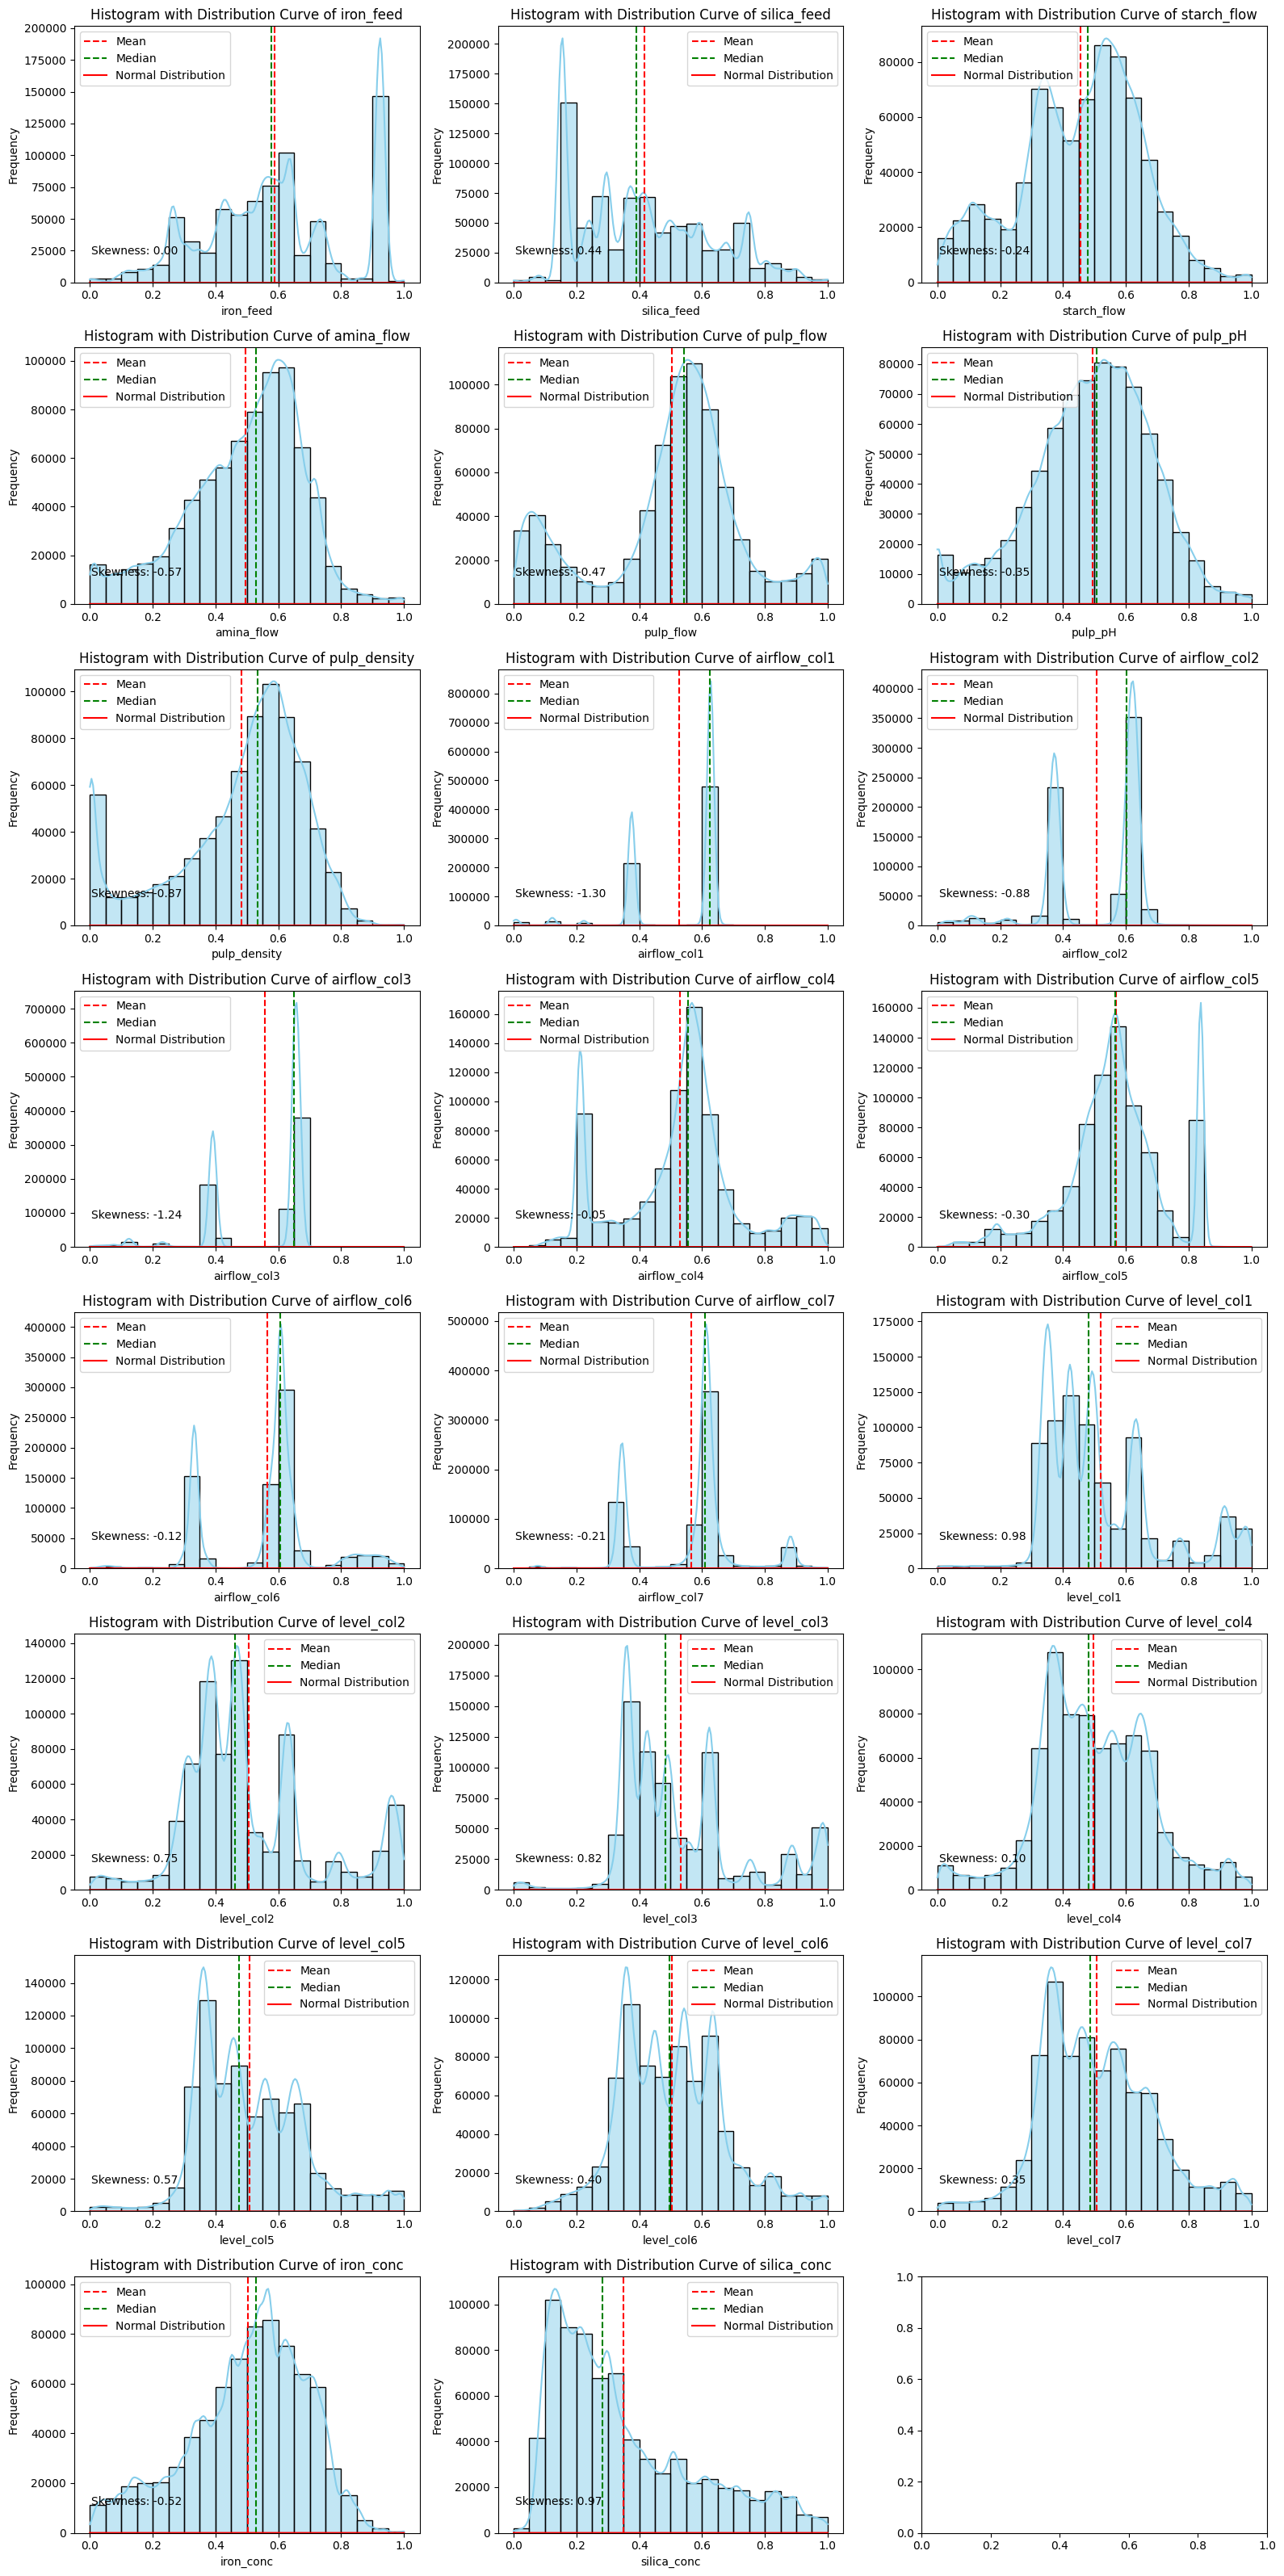

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, norm

# Selecting the variables for histogram plotting
variables = ["iron_feed", "silica_feed", "starch_flow", "amina_flow", "pulp_flow",
             "pulp_pH", "pulp_density", "airflow_col1", "airflow_col2", "airflow_col3",
             "airflow_col4", "airflow_col5", "airflow_col6", "airflow_col7", "level_col1",
             "level_col2", "level_col3", "level_col4", "level_col5", "level_col6",
             "level_col7", "iron_conc", "silica_conc"]

# Determine the number of rows and columns for subplots
num_variables = len(variables)
num_rows = (num_variables + 2) // 3  # Round up to the nearest integer

# Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(16, num_rows * 4))

# Iterate over variables and plot histograms with distribution curve
for i, variable in enumerate(variables):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Plot histogram
    sns.histplot(flotation[variable], kde=True, bins=20, color='skyblue', ax=ax)
    
    # Add a line representing the skewness
    skewness = skew(flotation[variable])
    ax.axvline(x=flotation[variable].mean(), color='r', linestyle='--', label='Mean')
    ax.axvline(x=flotation[variable].median(), color='g', linestyle='--', label='Median')
    
    # Add distribution curve
    x = np.linspace(flotation[variable].min(), flotation[variable].max(), 100)
    mu, sigma = norm.fit(flotation[variable])
    y = norm.pdf(x, mu, sigma)
    ax.plot(x, y, 'r-', label='Normal Distribution')
    
    # Display the degree of skewness
    ax.text(0.05, 0.1, f"Skewness: {skewness:.2f}", transform=ax.transAxes, ha='left', va='bottom')
    
    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram with Distribution Curve of ' + variable)
    ax.legend()

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


Some variables are very low skewness degree. No need to transform below variables:
- Skewness for iron_feed : 0.00041304696792240475
- Skewness for starch_flow : -0.24258915159667213
- Skewness for airflow_col4 : -0.05012623656558369
- Skewness for airflow_col6 : -0.11556223504540256
- Skewness for airflow_col7 : -0.20868515032924473
- Skewness for level_col4 : 0.09900997598685346

- To normalize skewed variables, we will use Logarithmic Transformation

In [ ]:
# Selecting the skewed variables for normalization
skewed_variables = ["silica_feed", "amina_flow", "pulp_flow", "pulp_pH", "pulp_density", 
                         "airflow_col1", "airflow_col2", "airflow_col3", "airflow_col5", 
                         "level_col1", "level_col2", "level_col3", "level_col4", "level_col5", 
                         "level_col6", "level_col7", "iron_conc", "silica_conc"]

# Apply logarithmic transformation to skewed variables
for variable in skewed_variables:
    flotation[variable] = np.log(flotation[variable] + 1)  # Adding 1 to avoid taking log of zero or negative values

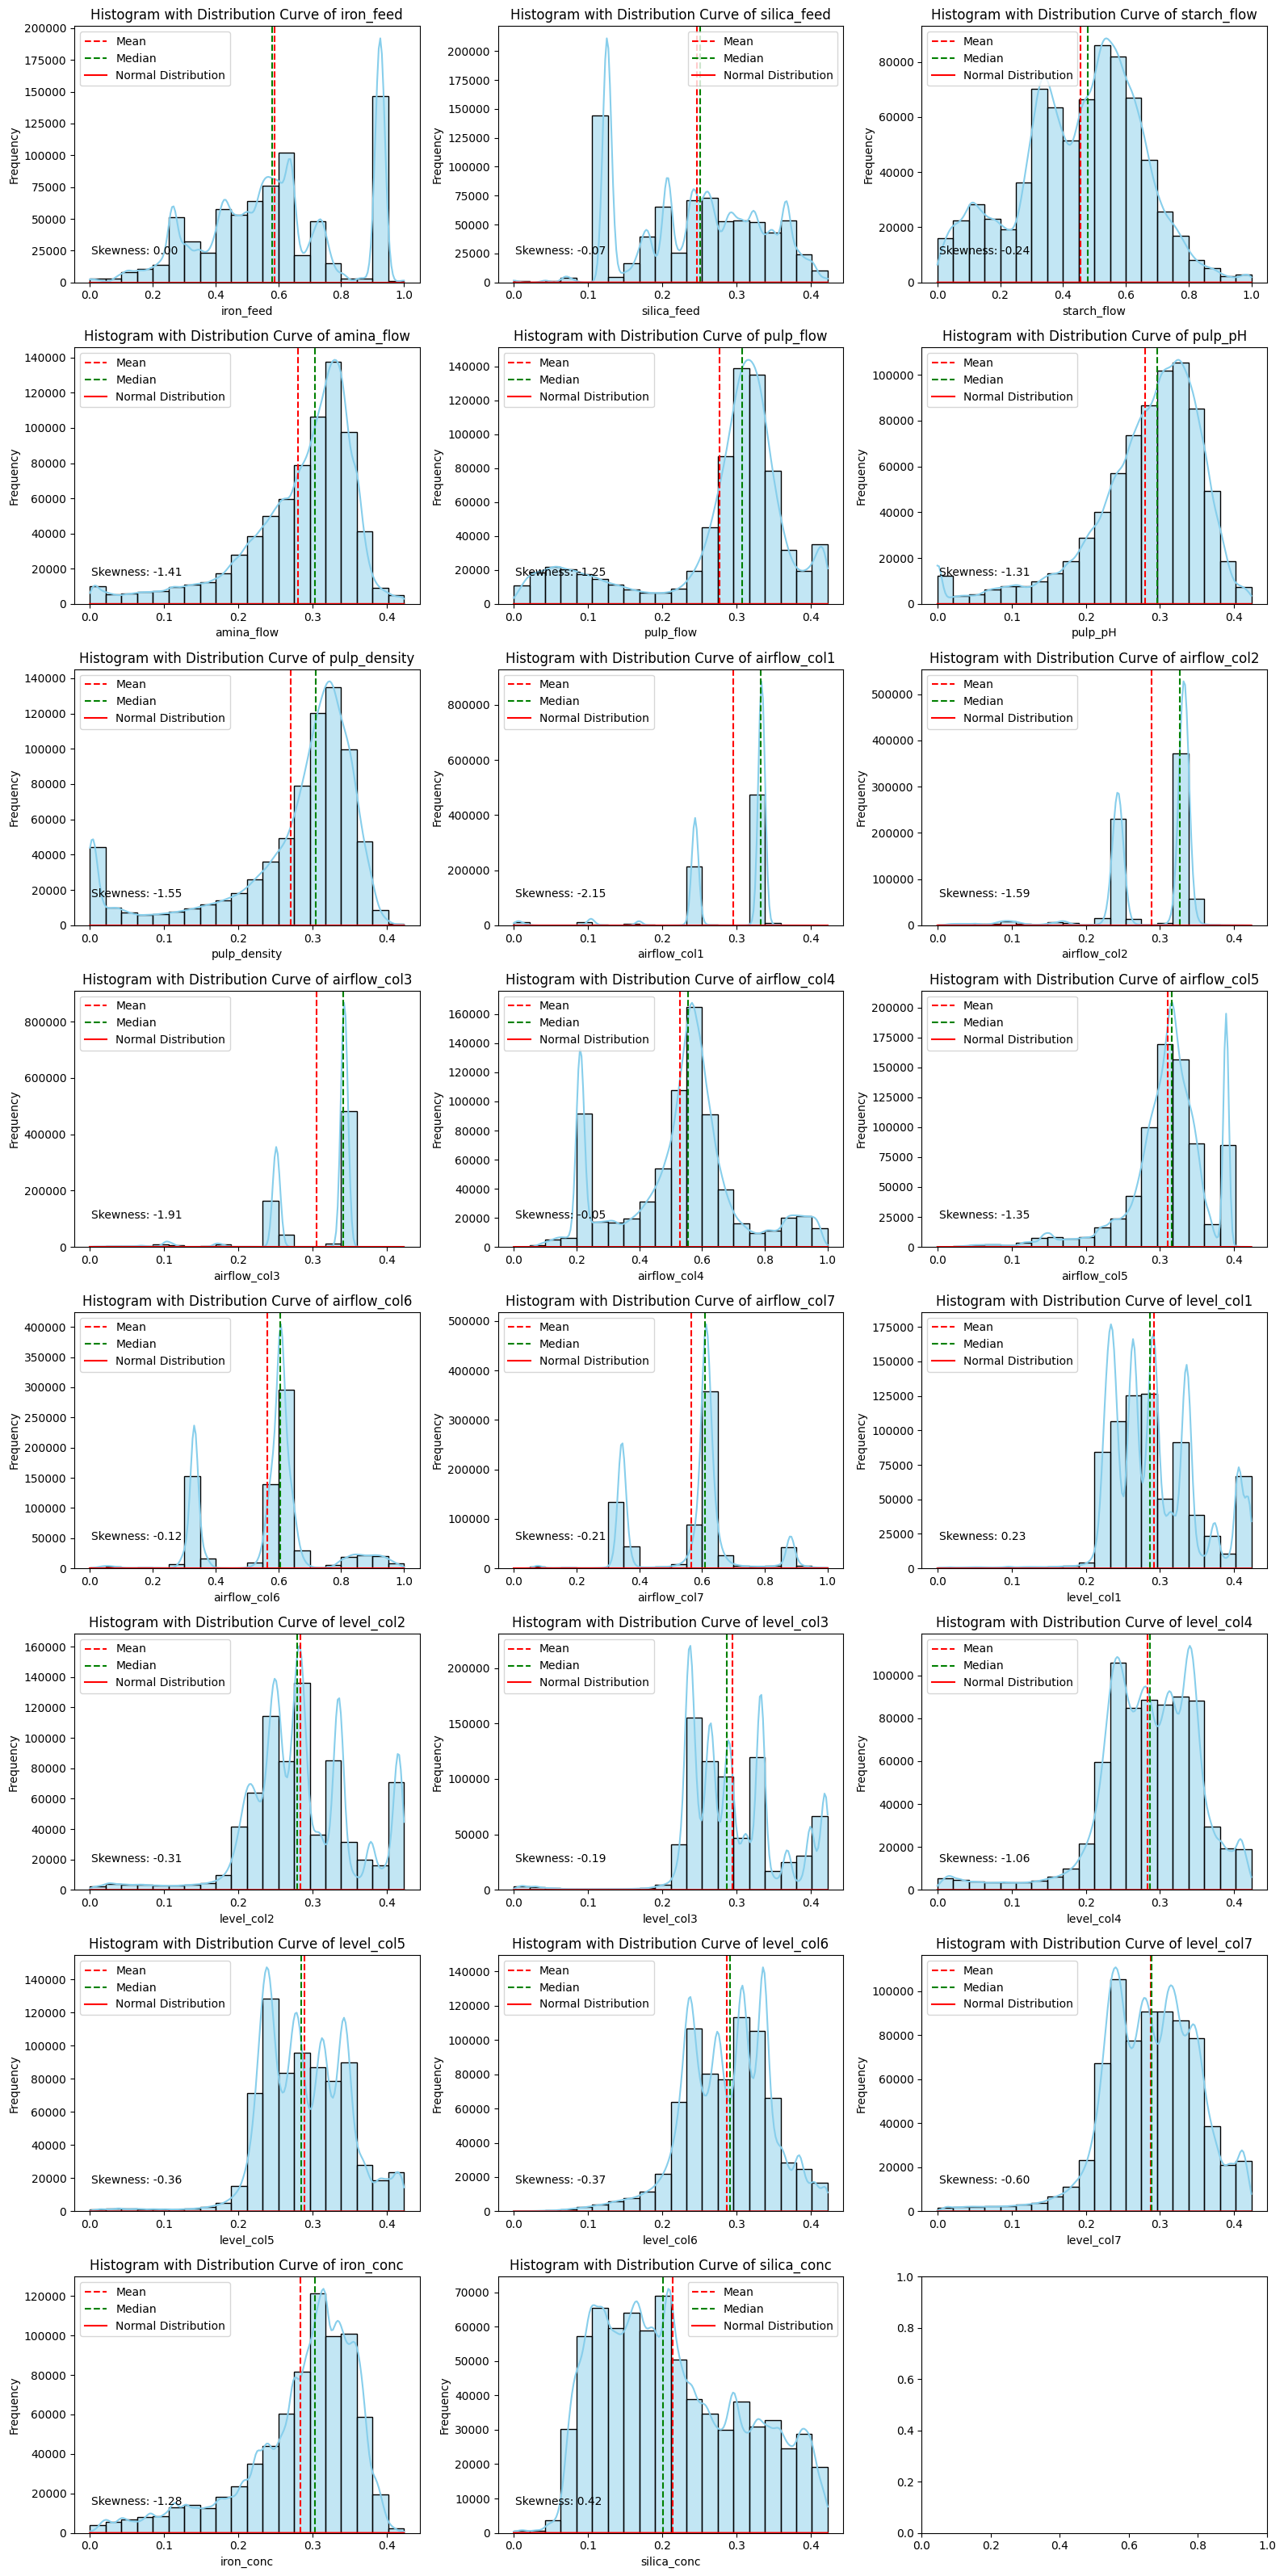

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, norm

# Selecting the variables for histogram plotting
variables = ["iron_feed", "silica_feed", "starch_flow", "amina_flow", "pulp_flow",
             "pulp_pH", "pulp_density", "airflow_col1", "airflow_col2", "airflow_col3",
             "airflow_col4", "airflow_col5", "airflow_col6", "airflow_col7", "level_col1",
             "level_col2", "level_col3", "level_col4", "level_col5", "level_col6",
             "level_col7", "iron_conc", "silica_conc"]

# Determine the number of rows and columns for subplots
num_variables = len(variables)
num_rows = (num_variables + 2) // 3  # Round up to the nearest integer

# Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(16, num_rows * 4))

# Iterate over variables and plot histograms with distribution curve
for i, variable in enumerate(variables):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Plot histogram
    sns.histplot(flotation[variable], kde=True, bins=20, color='skyblue', ax=ax)
    
    # Add a line representing the skewness
    skewness = skew(flotation[variable])
    ax.axvline(x=flotation[variable].mean(), color='r', linestyle='--', label='Mean')
    ax.axvline(x=flotation[variable].median(), color='g', linestyle='--', label='Median')
    
    # Add distribution curve
    x = np.linspace(flotation[variable].min(), flotation[variable].max(), 100)
    mu, sigma = norm.fit(flotation[variable])
    y = norm.pdf(x, mu, sigma)
    ax.plot(x, y, 'r-', label='Normal Distribution')
    
    # Display the degree of skewness
    ax.text(0.05, 0.1, f"Skewness: {skewness:.2f}", transform=ax.transAxes, ha='left', va='bottom')
    
    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram with Distribution Curve of ' + variable)
    ax.legend()

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


###**4.7. Corellation between the variables**

In [ ]:
# Calculate the correlation matrix
correlation_matrix = flotation.corr()
correlation_matrix

iron_feed  silica_feed  starch_flow  amina_flow  pulp_flow  \
iron_feed      1.000000    -0.971876     0.027869   -0.088128   0.161138   
silica_feed   -0.971876     1.000000    -0.016089    0.078553  -0.151053   
starch_flow    0.027869    -0.016089     1.000000    0.254749   0.042962   
amina_flow    -0.088128     0.078553     0.254749    1.000000   0.212597   
pulp_flow      0.161138    -0.151053     0.042962    0.212597   1.000000   
pulp_pH        0.007687     0.008033     0.263497    0.124025   0.117989   
pulp_density  -0.125657     0.104287     0.225990    0.655352   0.012733   
airflow_col1  -0.061945     0.091544     0.191501    0.111560  -0.138482   
airflow_col2  -0.169021     0.182428     0.187065    0.123346  -0.119294   
airflow_col3  -0.061783     0.083975     0.183637    0.102168  -0.141355   
airflow_col4  -0.137072     0.160606     0.093660    0.015594  -0.156356   
airflow_col5   0.121718    -0.130858    -0.088208   -0.044929   0.166792   
airflow_col6  -0.042435     0.067505     0.215850    0.120076  -0.159391   
airflow_col7  -0.016156     0.045203     0.194944    0.079674  -0.141197   
level_col1     0.029678    -0.038294    -0.294159   -0.268700  -0.008920   
level_col2     0.021090    -0.037010    -0.278174   -0.234701  -0.008476   
level_col3     0.015329    -0.022672    -0.301586   -0.287252  -0.054637   
level_col4     0.016646    -0.034167    -0.011927   -0.179816  -0.010723   
level_col5     0.023928    -0.043942    -0.054836   -0.211502   0.001237   
level_col6     0.003890    -0.019580    -0.071543   -0.197984  -0.016946   
level_col7     0.026122    -0.046484    -0.037721   -0.167756   0.015902   
iron_conc      0.055844    -0.044403     0.070058   -0.110742   0.082778   
silica_conc   -0.077179     0.072676    -0.066813    0.156981   0.008497   

               pulp_pH  pulp_density  airflow_col1  airflow_col2  \
iron_feed     0.007687     -0.125657     -0.061945     -0.169021   
silica_feed   0.008033      0.104287      0.091544      0.182428   
starch_flow   0.263497      0.225990      0.191501      0.187065   
amina_flow    0.124025      0.655352      0.111560      0.123346   
pulp_flow     0.117989      0.012733     -0.138482     -0.119294   
pulp_pH       1.000000      0.115964      0.162613      0.144379   
pulp_density  0.115964      1.000000     -0.004740      0.026546   
airflow_col1  0.162613     -0.004740      1.000000      0.848168   
airflow_col2  0.144379      0.026546      0.848168      1.000000   
airflow_col3  0.192966     -0.031353      0.954496      0.860348   
airflow_col4  0.150005     -0.097692      0.474472      0.433952   
airflow_col5 -0.139962      0.043593     -0.204492     -0.182716   
airflow_col6  0.113713     -0.030515      0.663089      0.588680   
airflow_col7  0.174494     -0.052175      0.646716      0.578528   
level_col1   -0.166373     -0.111556     -0.442249     -0.432858   
level_col2   -0.154349     -0.093037     -0.426596     -0.423850   
level_col3   -0.140600     -0.149803     -0.372320     -0.366171   
level_col4    0.045292     -0.086387     -0.063151     -0.075872   
level_col5    0.011757     -0.139891     -0.092814     -0.112315   
level_col6   -0.075478     -0.099982     -0.119449     -0.118141   
level_col7    0.018084     -0.085164     -0.111736     -0.113640   
iron_conc     0.192443      0.015150      0.098089      0.058184   
silica_conc  -0.147211      0.047002     -0.219076     -0.167259   

              airflow_col3  ...  airflow_col7  level_col1  level_col2  \
iron_feed        -0.061783  ...     -0.016156    0.029678    0.021090   
silica_feed       0.083975  ...      0.045203   -0.038294   -0.037010   
starch_flow       0.183637  ...      0.194944   -0.294159   -0.278174   
amina_flow        0.102168  ...      0.079674   -0.268700   -0.234701   
pulp_flow        -0.141355  ...     -0.141197   -0.008920   -0.008476   
pulp_pH           0.192966  ...      0.174494   -0.166373   -0.154349   
pulp_density     -0.031353  ...     -0.052175

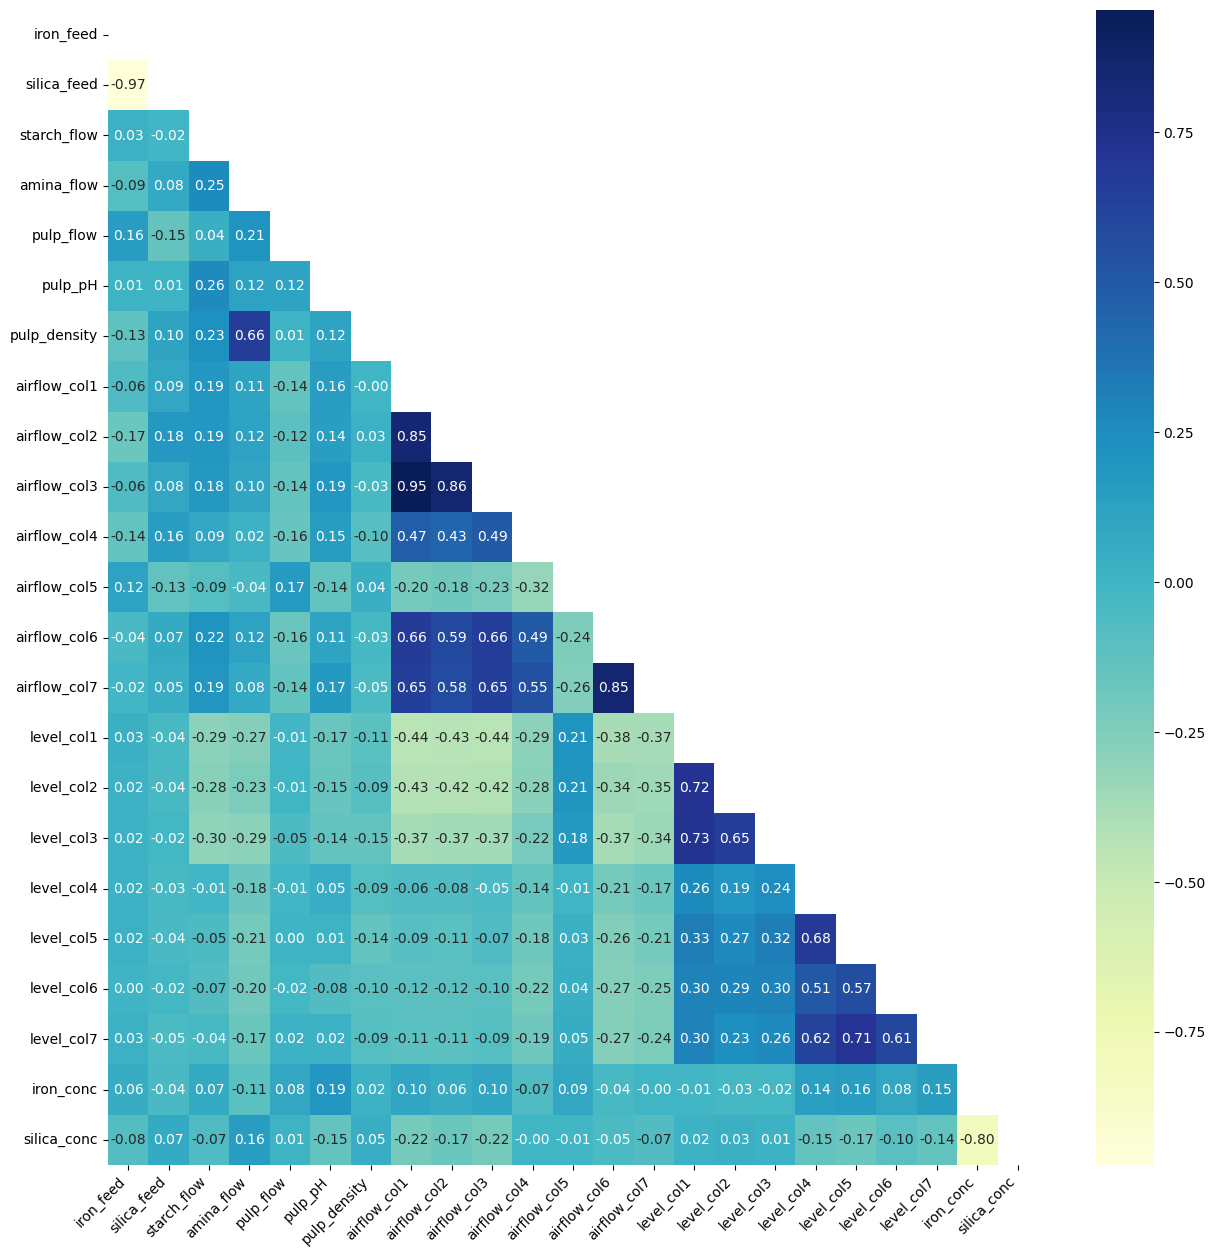

In [ ]:
# Plot corellation martix heatmap of variables
fig, ax = plt.subplots(figsize=(15, 15))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, 
            annot=True, fmt=".2f", cmap="YlGnBu")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.show()

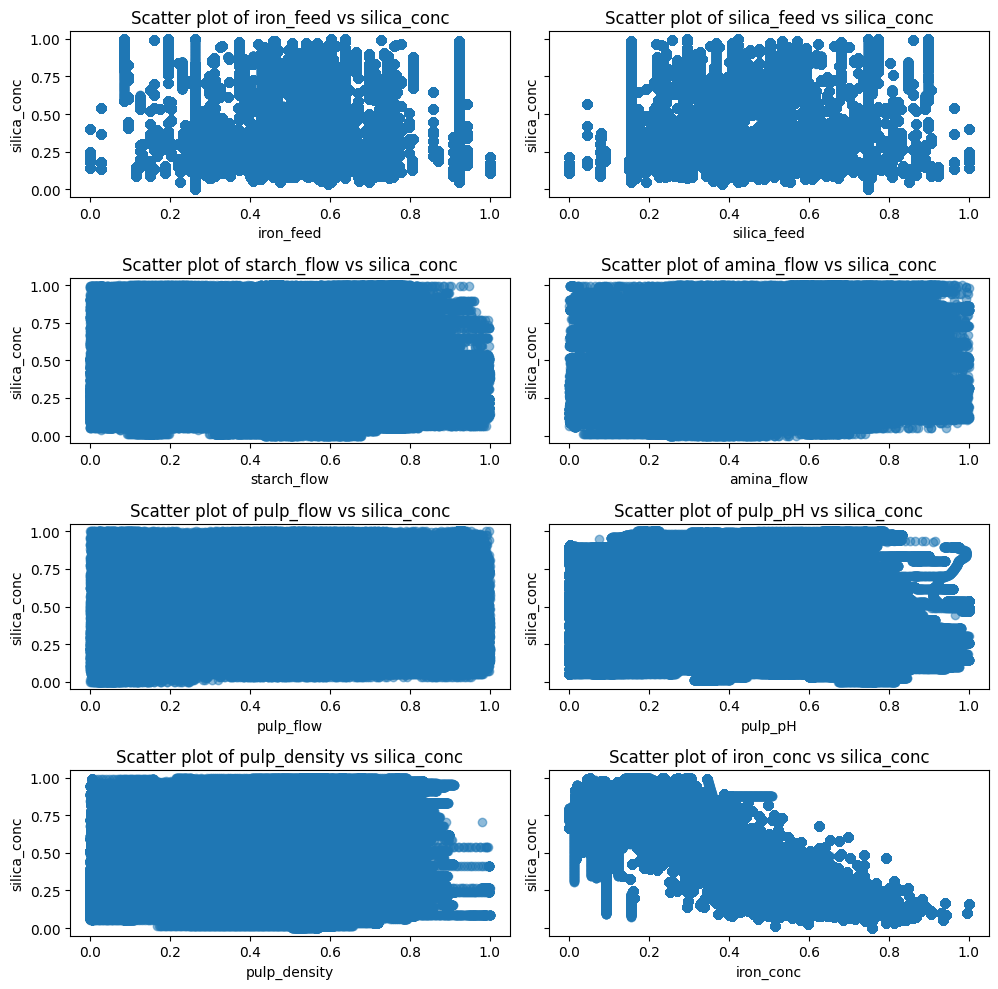

In [ ]:
colnames = ["iron_feed", "silica_feed", "starch_flow", "amina_flow", "pulp_flow",
            "pulp_pH", "pulp_density", "iron_conc"]

target = "silica_conc"

# Create subplots for each independent variable
fig, axes = plt.subplots(4, 2, figsize=(10, 10), sharey=True)
axes = axes.flatten()

for i, colname in enumerate(colnames):
    ax = axes[i]
    ax.scatter(flotation[colname], flotation[target], alpha=0.5)
    ax.set_xlabel(colname)
    ax.set_ylabel("silica_conc")
    ax.set_title(f"Scatter plot of {colname} vs silica_conc")

# Remove empty subplots if there are any
if len(colnames) < len(axes):
    for j in range(len(colnames), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

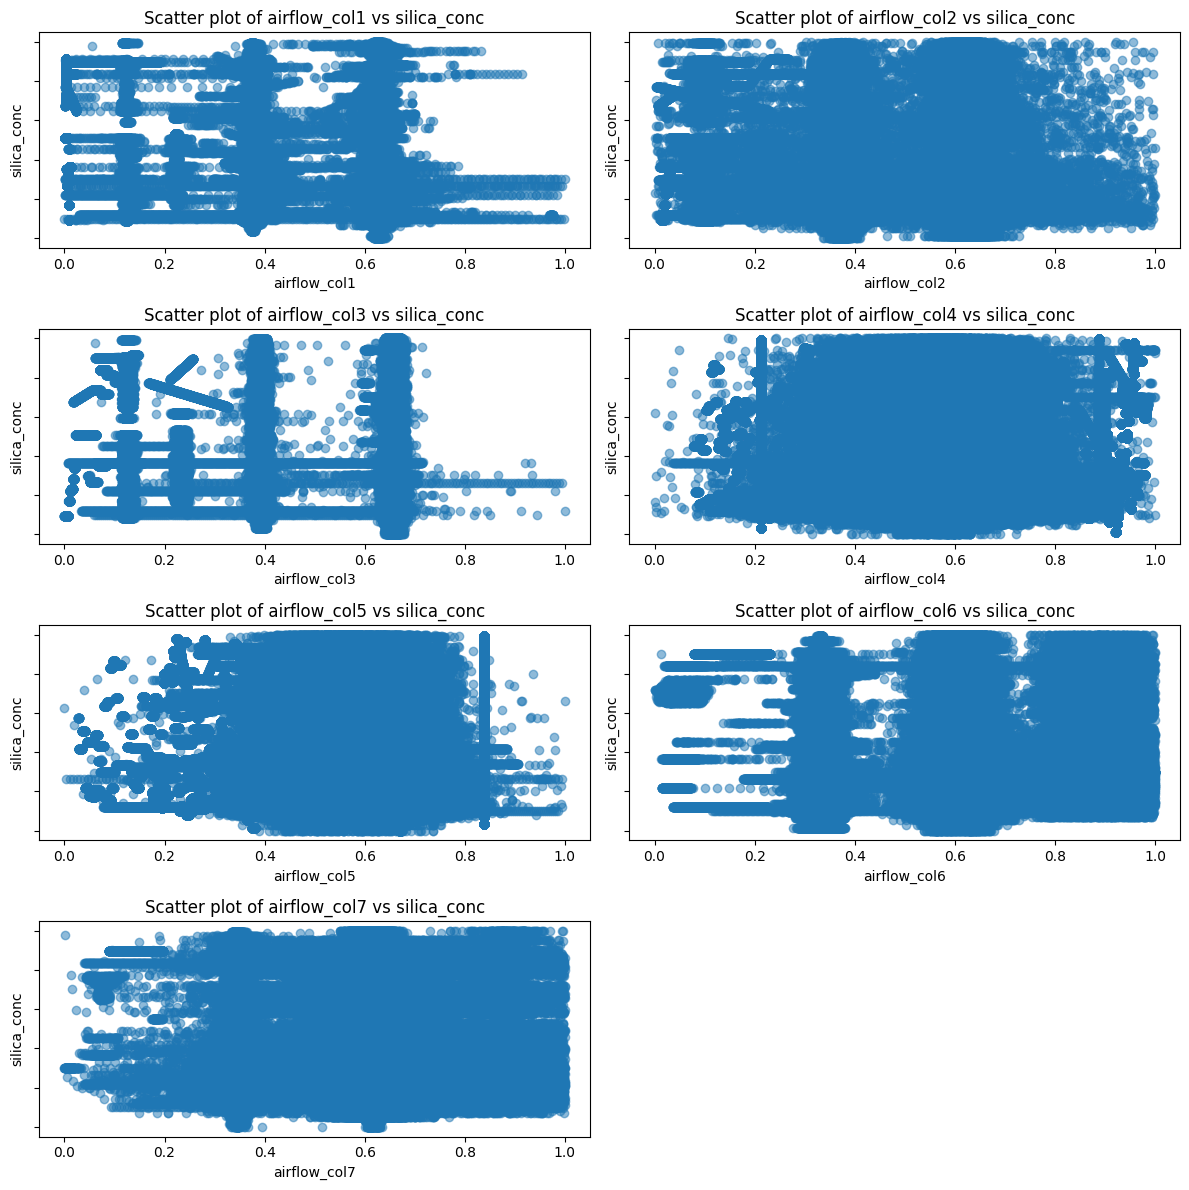

In [ ]:
colnames = ["airflow_col1", "airflow_col2", "airflow_col3", 
            "airflow_col4", "airflow_col5", "airflow_col6", "airflow_col7"]

target = "silica_conc"

fig, axes = plt.subplots(4, 2, figsize=(12, 12), sharey=True)
axes = axes.flatten()

# Plot each independent variable separately
for i, colname in enumerate(colnames):
    ax = axes[i]
    ax.scatter(flotation[colname], flotation[target], alpha=0.5)
    ax.set_xlabel(colname)
    ax.set_ylabel("silica_conc")
    ax.set_title(f"Scatter plot of {colname} vs silica_conc")
    ax.set_yticklabels([colname], rotation=45)

if len(colnames) < len(axes):
    for j in range(len(colnames), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

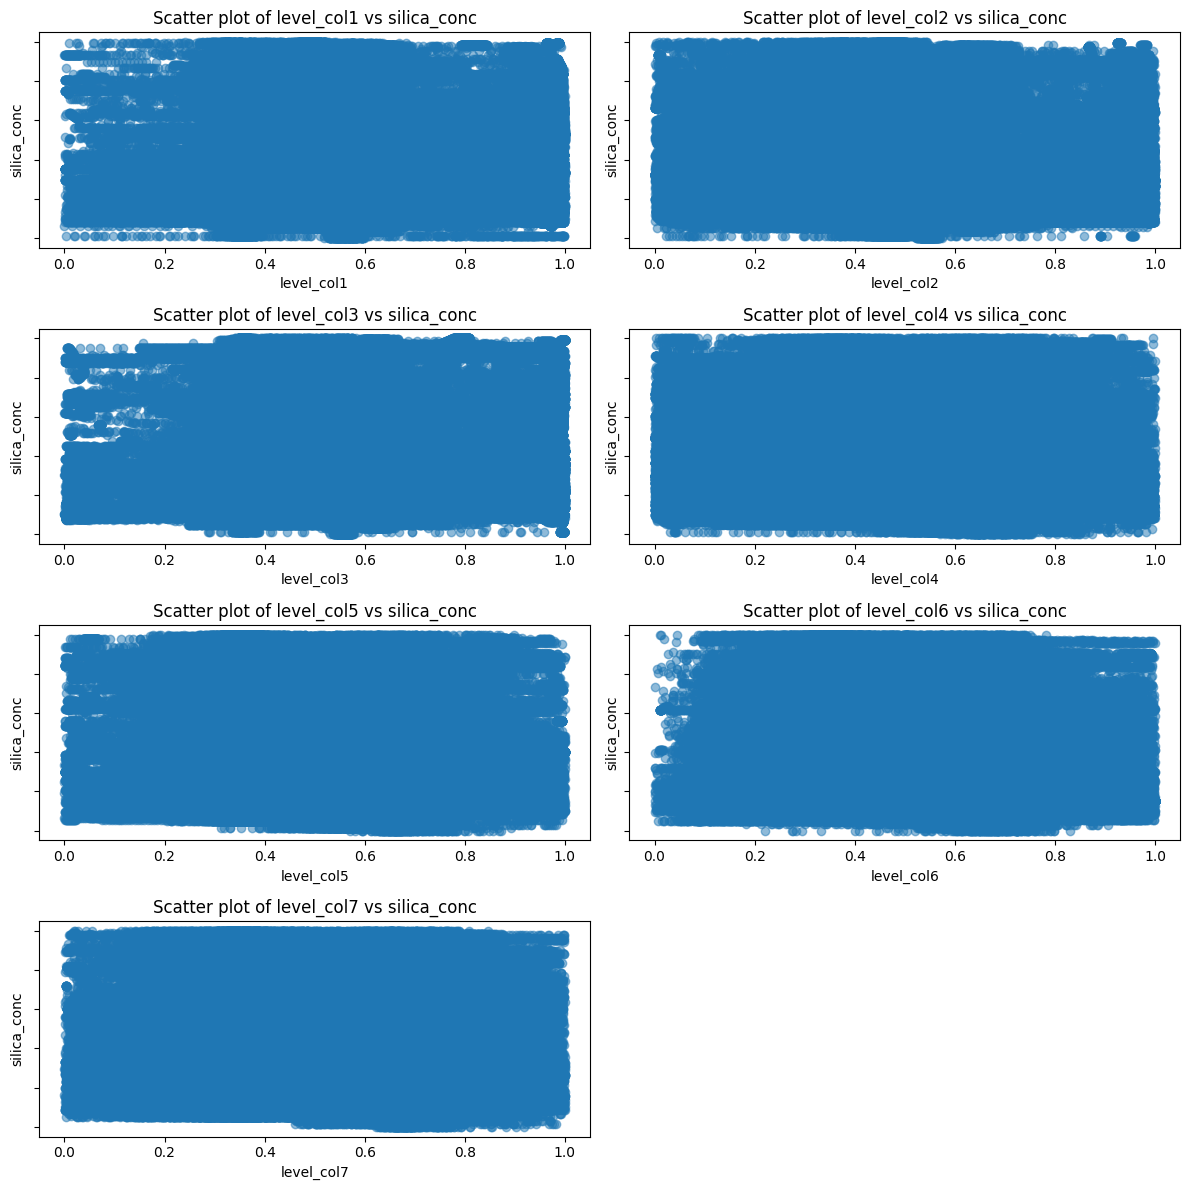

In [ ]:
colnames = ["level_col1", "level_col2", "level_col3",
            "level_col4", "level_col5", "level_col6", "level_col7"]

target = "silica_conc"

fig, axes = plt.subplots(4, 2, figsize=(12, 12), sharey=True)
axes = axes.flatten()

# Plot each independent variable separately
for i, colname in enumerate(colnames):
    ax = axes[i]
    ax.scatter(flotation[colname], flotation[target], alpha=0.5)
    ax.set_xlabel(colname)
    ax.set_ylabel("silica_conc")
    ax.set_title(f"Scatter plot of {colname} vs silica_conc")
    ax.set_yticklabels([colname], rotation=45)

if len(colnames) < len(axes):
    for j in range(len(colnames), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

###**4.8. Check Outliers**

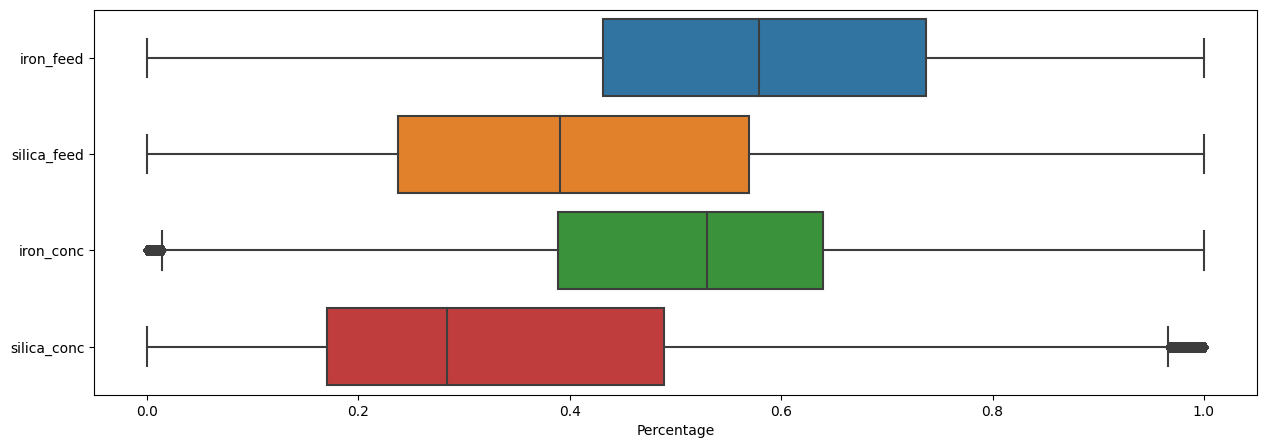

In [ ]:
#box plots of input and output values 
plt.figure(figsize = (15, 5))
sns.boxplot(data = flotation[["iron_feed", "silica_feed", "iron_conc", "silica_conc"]], orient = 'h')
plt.xlabel('Percentage');

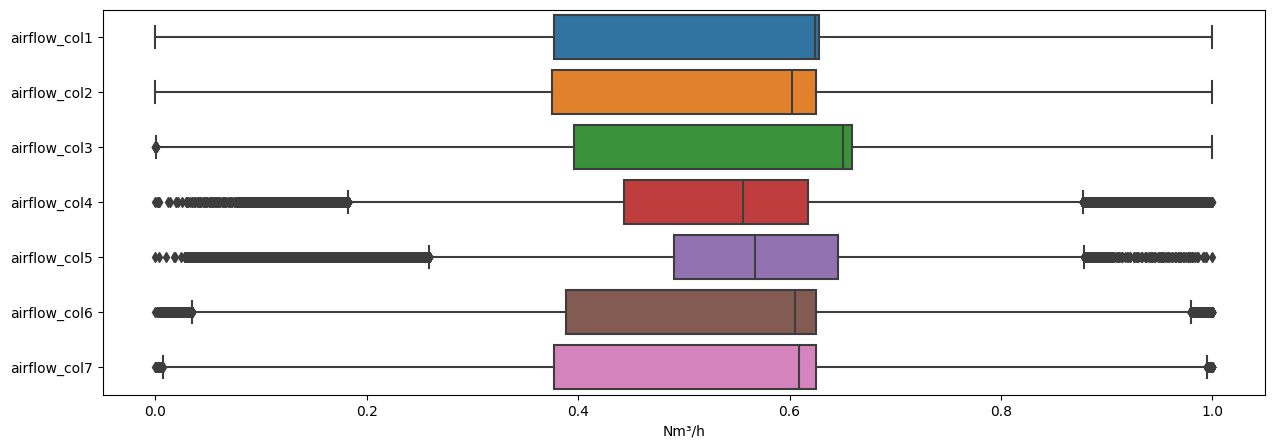

In [ ]:
#box plots of airflow values 
plt.figure(figsize = (15, 5))
sns.boxplot(data = flotation[["airflow_col1", "airflow_col2", "airflow_col3", 
                              "airflow_col4", "airflow_col5", "airflow_col6", 
                              "airflow_col7"]], orient = 'h')
plt.xlabel('Nm³/h');

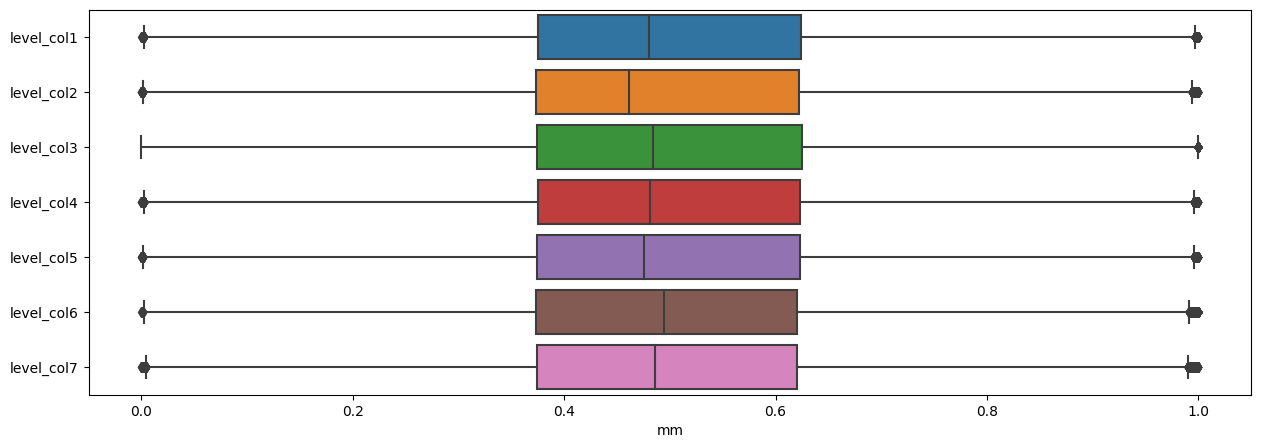

In [ ]:
#box plots of froth level values 
plt.figure(figsize = (15, 5))
sns.boxplot(data = flotation[["level_col1", "level_col2", "level_col3", 
                              "level_col4", "level_col5","level_col6", 
                              "level_col7"]], orient = 'h')
plt.xlabel('mm');

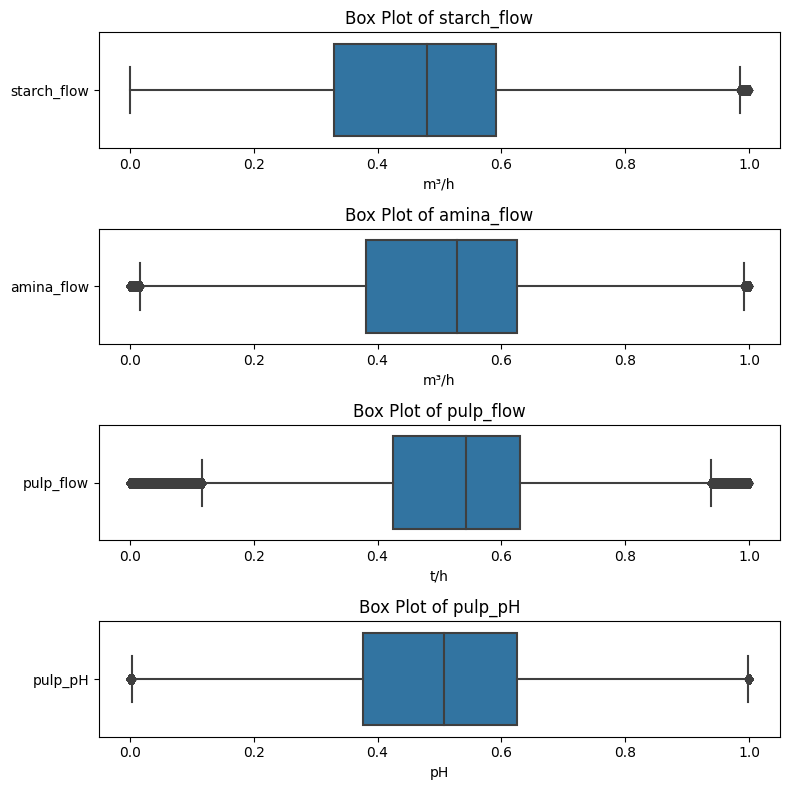

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(8, 8))

# Box plots for starch_flow
sns.boxplot(data=flotation[["starch_flow"]], orient='h', ax=axes[0])
axes[0].set_xlabel('m³/h')
axes[0].set_title('Box Plot of starch_flow')

# Box plots for amina_flow
sns.boxplot(data=flotation[["amina_flow"]], orient='h', ax=axes[1])
axes[1].set_xlabel('m³/h')
axes[1].set_title('Box Plot of amina_flow')

# Box plots for pulp_flow
sns.boxplot(data=flotation[["pulp_flow"]], orient='h', ax=axes[2])
axes[2].set_xlabel('t/h')
axes[2].set_title('Box Plot of pulp_flow')

# Box plots for pulp_pH
sns.boxplot(data=flotation[["pulp_pH"]], orient='h', ax=axes[3])
axes[3].set_xlabel('pH')
axes[3].set_title('Box Plot of pulp_pH')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Specify the columns to consider for outlier removal
columns_to_check = ["iron_feed", "silica_feed", "starch_flow",
               "amina_flow", "pulp_flow", "pulp_pH", "pulp_density",
               "airflow_col1", "airflow_col2", "airflow_col3",
               "airflow_col4", "airflow_col5", "airflow_col6", "airflow_col7", 
               "level_col1", "level_col2", "level_col3", "level_col4", "level_col5", 
               "level_col6", "level_col7",
               "iron_conc", "silica_conc"]

# Loop over each column to identify and eliminate outliers
for column in columns_to_check:
    # Calculate the lower and upper thresholds
    lower_threshold = np.percentile(flotation[column], 25) - 1.5 * (np.percentile(flotation[column], 75) - np.percentile(flotation[column], 25))
    upper_threshold = np.percentile(flotation[column], 75) + 1.5 * (np.percentile(flotation[column], 75) - np.percentile(flotation[column], 25))
    
    # Identify outliers
    outliers = flotation[(flotation[column] < lower_threshold) | (flotation[column] > upper_threshold)]
    
    # Remove outliers
    modified_flotation = flotation[(flotation[column] >= lower_threshold) & (flotation[column] <= upper_threshold)]

In [ ]:
modified_flotation.shape

(731525, 23)

Now data points of dataset has decreased from 736282 to 731525

###**4.7. Check Skewness**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot

def check_skewness(col):
    sns.distplot(flotation[col], fit=norm)
    fig = plt.figure()
    res = probplot(flotation[col], plot=plt)
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(flotation[col])
    print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


 mu = 0.35 and sigma = 0.23



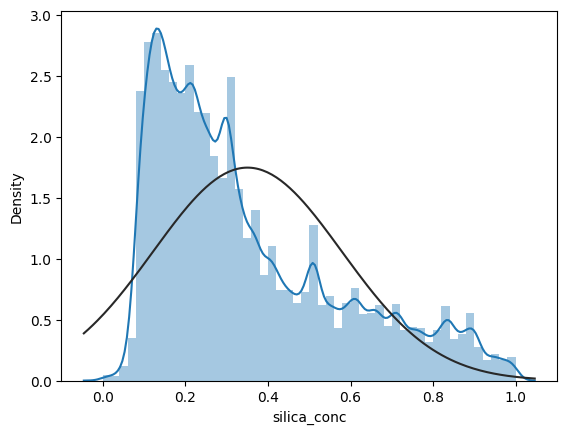

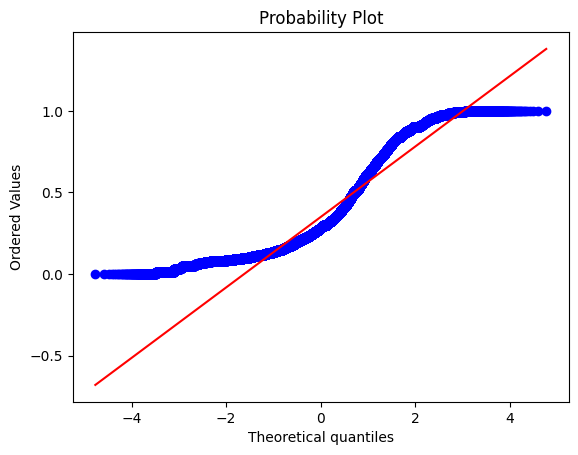

In [ ]:
check_skewness("silica_conc")


 mu = 0.42 and sigma = 0.21



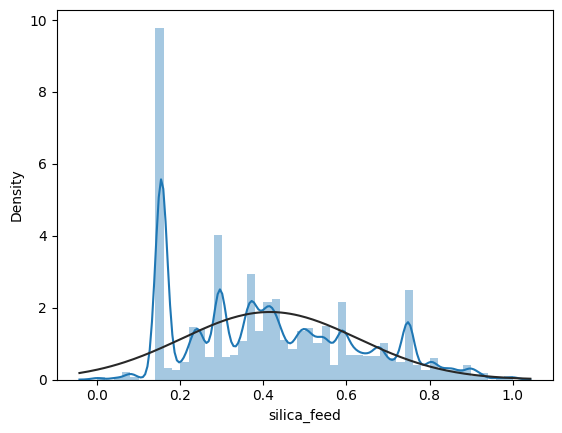

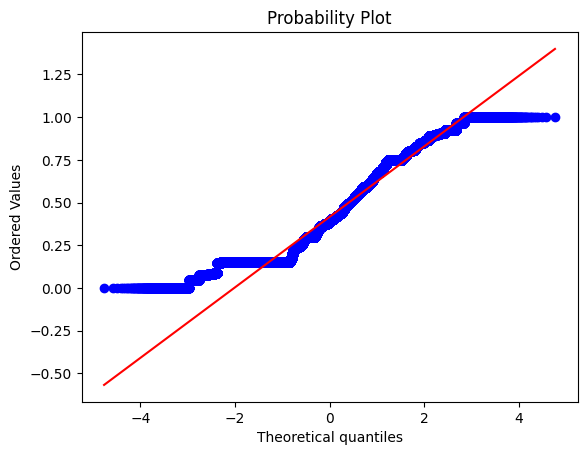

In [ ]:
check_skewness("silica_feed")


 mu = 0.46 and sigma = 0.19



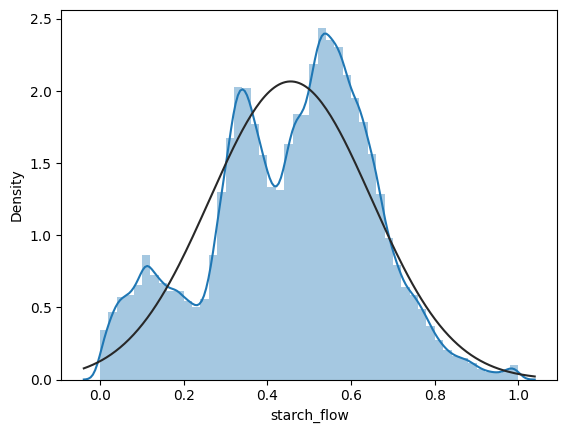

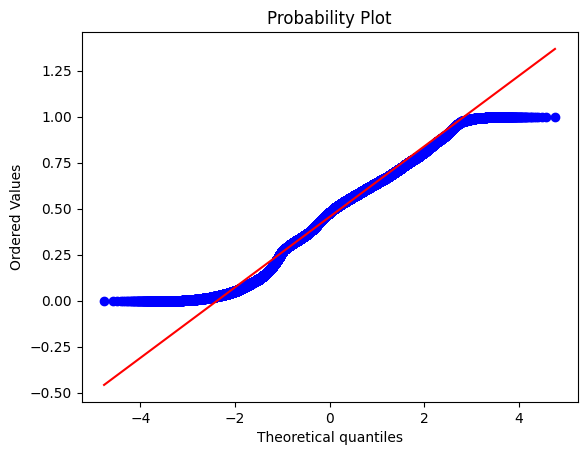

In [ ]:
check_skewness("starch_flow")


 mu = 0.52 and sigma = 0.18



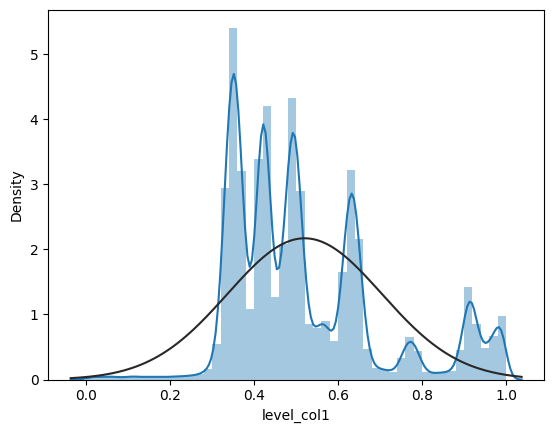

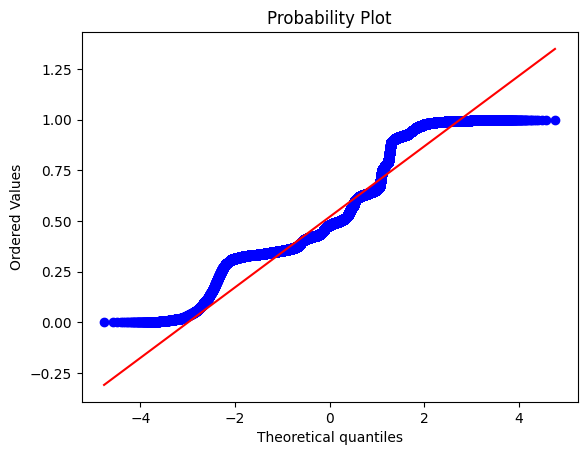

In [ ]:
check_skewness("level_col1")


 mu = 0.41 and sigma = 0.12



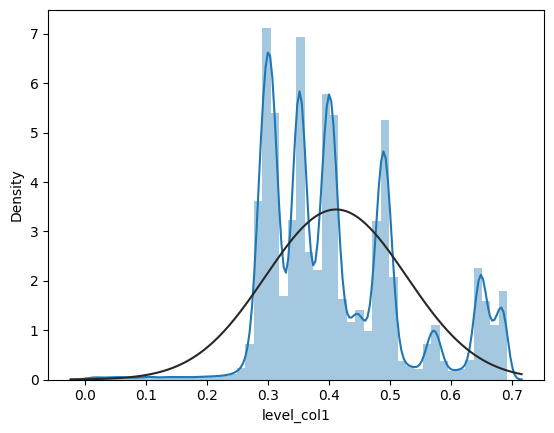

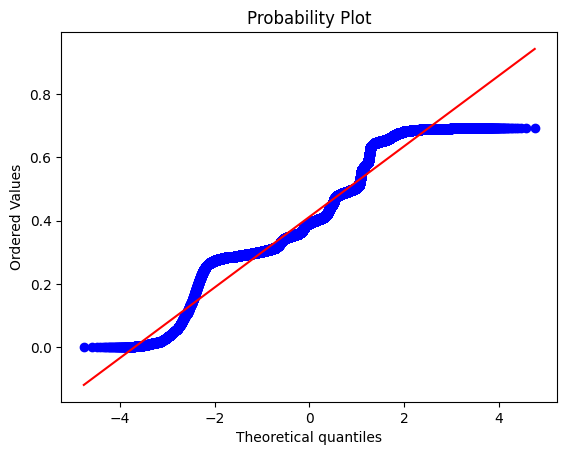

In [ ]:
flotation["level_col1"] = np.log1p(flotation["level_col1"])
check_skewness("level_col1")

This distribution is positively skewed. Notice that the black curve is more deviated towards the right. If you encounter that your predictive (response) variable is skewed, it is recommended to fix the skewness to make good decisions by the model.

Okay, So how do I fix the skewness?
The best way to fix it is to perform a log transform of the same data, with the intent to reduce the skewness.


 mu = 0.25 and sigma = 0.12



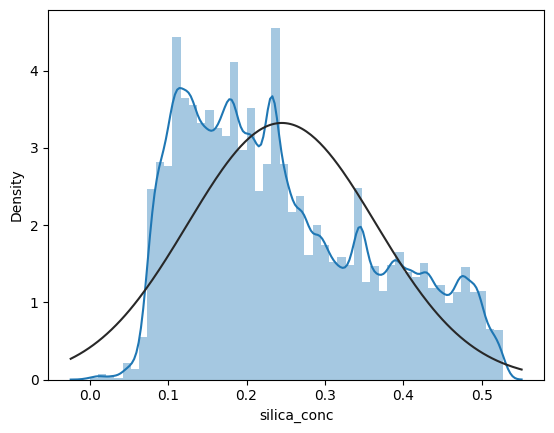

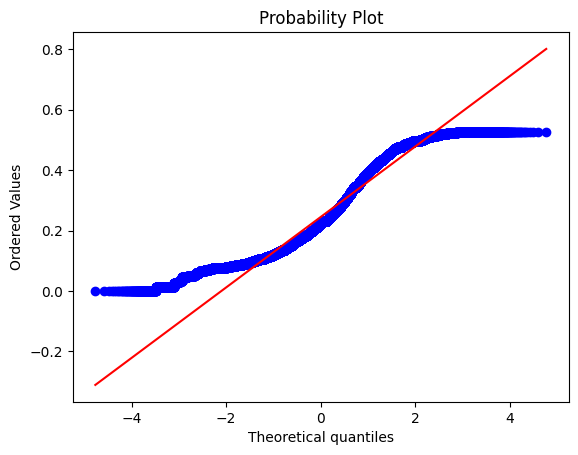

In [ ]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
flotation["silica_conc"] = np.log1p(flotation["silica_conc"])
check_skewness("silica_conc")

##**5. Modelling**

##**6. Evaluating**

##**7. Tunning Model**